# Suspense at the Wildlife Preserve: "Cheep" Shots

## Goals:
1. Using the bird call collection and the included map of the Wildlife Preserve, characterize the patterns of all of the bird species in the Preserve over the time of the collection. Please assume we have a reasonable distribution of sensors and human collectors providing the recordings, so that the patterns are reasonably representative of the bird locations across the area. Do you detect any trends or anomalies in the patterns?
2. Turn your attention to the set of bird calls supplied by Kasios. Does this set support the claim of Pipits being found across the Preserve? A machine learning approach using the bird call library may help your investigation. What is the role of visualization in your analysis of the Kasios bird calls?
3. Formulate a hypotheses concerning the state of the Rose Crested Blue Pipit. What are your primary pieces of evidence to support your assertion? What next steps should be taken in the investigation to either support or refute the Kasios claim that the Pipits are actually thriving across the Boonsong Lekagul Wildlife Preserve?


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa  # for audio processing
import cv2
import IPython.display as ipd
import re
import datetime

## Import Data

In [56]:
# rename all the mpg files to correspond with the file IDs.

def rename_mpg_files(folder_path):
    """
    Renames MPG files in the specified folder to match the file IDs.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith(".mp3"):
            file_id = filename.split("-")[-1].split(".")[0]
            new_filename = f"{file_id}.mp3"
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))

In [57]:
def load_bird_data(csv_path):
    """
    Loads bird data from the specified CSV file into a pandas DataFrame.
    """
    bird_data = pd.read_csv(csv_path)
    return bird_data

In [58]:
def load_map(map_path):
    """
    Loads the BMP map from the specified file path.
    """
    map_image = cv2.imread(map_path)
    return map_image

In [59]:
map_path = "Lekagul Roadways 2018.bmp"
map_image = load_map(map_path)

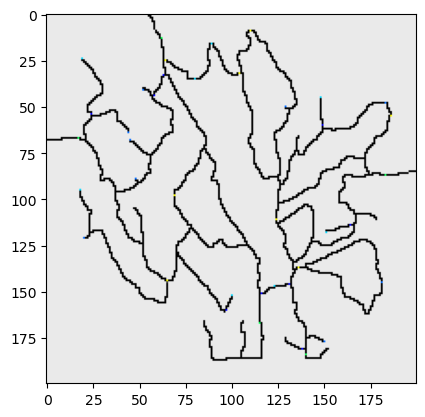

In [60]:
plt.imshow(map_image)

In [61]:
def load_audio(audio_path):
    """
    Loads the audio file from the specified file path.
    """
    audio, sample_rate = librosa.load(audio_path, sr=44100)
    return audio, sample_rate

In [62]:
filepath = "/mnt/c/Users/Owner/Desktop/COMP 4449 Capstone/comp-4449-final-cheepshots/Test Birds from Kasios/1.mp3"
ipd.Audio(filepath)

In [63]:
bird_data = load_bird_data("/mnt/c/Users/Owner/Desktop/COMP 4449 Capstone/comp-4449-final-cheepshots/AllBirdsv4.csv")
bird_data.head()

File ID             English_name Vocalization_type   Quality   Time  \
0   402254  Rose-crested Blue Pipit              call  no score  13:30   
1   406171  Rose-crested Blue Pipit              call         A   7:48   
2   405901  Rose-crested Blue Pipit              call         A  12:00   
3   405548  Rose-crested Blue Pipit              song         A  11:00   
4   401782  Rose-crested Blue Pipit              song         A   6:00   

        Date    X    Y  
0   2/8/2018   49   63  
1   6/7/2017  125  133  
2   2/8/2018   58   76  
3  3/10/2018   55  125  
4  6/29/2008  129  123

In [64]:
kasios_data = load_bird_data("/mnt/c/Users/Owner/Desktop/COMP 4449 Capstone/comp-4449-final-cheepshots/Test Birds Location.csv")
kasios_data.head()

ID    X    Y
0   1  140  119
1   2   63  153
2   3   70  136
3   4   78  150
4   5   60   90

In [65]:
print(bird_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   File ID            2081 non-null   int64 
 1   English_name       2081 non-null   object
 2   Vocalization_type  2081 non-null   object
 3   Quality            2081 non-null   object
 4   Time               2081 non-null   object
 5   Date               2081 non-null   object
 6   X                  2081 non-null   int64 
 7   Y                  2081 non-null   object
dtypes: int64(2), object(6)
memory usage: 130.2+ KB
None


In [66]:
def check_column_unique_values(df, column_name):
    """
    Checks the unique values of the specified column in the specified DataFrame.
    """
    unique_values = df[column_name].unique()
    print(f"Unique values for {column_name}: {unique_values}")

In [67]:
check_column_unique_values(bird_data, "English_name")

Unique values for English_name: ['Rose-crested Blue Pipit' 'Blue-collared Zipper' 'Bombadil'
 'Broad-winged Jojo' 'Canadian Cootamum' 'Carries Champagne Pipit'
 'Darkwing Sparrow' 'Eastern Corn Skeet' 'Green-tipped Scarlet Pipit'
 'Lesser Birchbeere' 'Orange Pine Plover' 'Ordinary Snape' 'Pinkfinch'
 'Purple Tooting Tout' 'Qax' 'Queenscoat' 'Bent-beak Riffraff'
 'Scrawny Jay' 'Vermillion Trillian']


In [68]:
check_column_unique_values(bird_data, "Vocalization_type")

Unique values for Vocalization_type: ['call' 'song' 'Song' 'call, song' '?' 'Call' 'Call, song' ' call' 'scold'
 'drumming' 'bill-snapping']


Vocalization type is tricky as I'm not sure if one birds scold is similiar to another birds song. We may not need vocalization types depending what the data from Kasios looks like.
For now we can clean the column data and see the distribution of vocalization types.

In [69]:
bird_data["Vocalization_type"] = bird_data["Vocalization_type"].str.lower().str.strip() # lowercase and strip whitespace
bird_data["Vocalization_type"] = bird_data["Vocalization_type"].str.replace("call, song", "call/song") # replace "call, song" with "call/song"
bird_data['Vocalization_type'] = bird_data['Vocalization_type'].replace({'?': 'other'}) # replace "?" with "other"
check_column_unique_values(bird_data, "Vocalization_type")

Unique values for Vocalization_type: ['call' 'song' 'call/song' 'other' 'scold' 'drumming' 'bill-snapping']


In [70]:
def plot_bar_chart(data_frame, column_name):
    """
    Create a bar chart to visualize the distribution of unique values in a column.
    """

    value_counts = data_frame[column_name].value_counts()

    plt.figure(figsize=(8, 6))
    value_counts.plot(kind='bar', color='skyblue')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.xticks(rotation=45)
    plt.show()

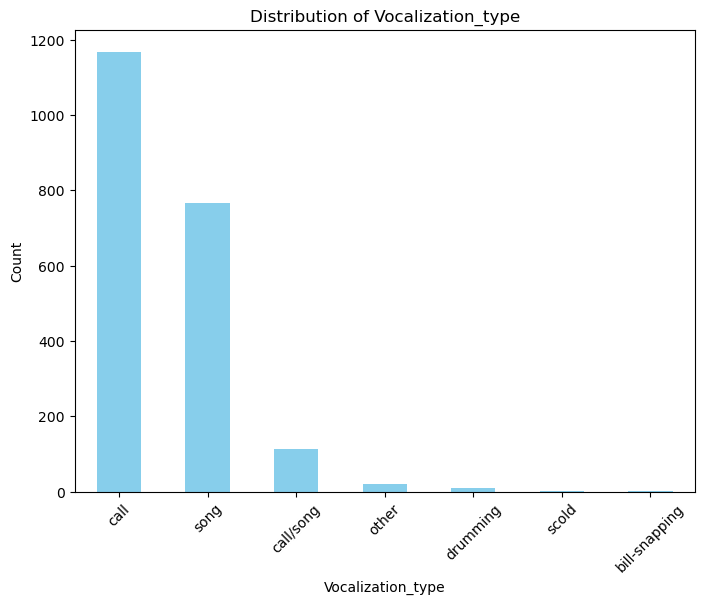

In [71]:
plot_bar_chart(bird_data, 'Vocalization_type')

Based on the bar chart, it's safe to remove any of the vocalization types that isn't call or song.

In [72]:
bird_data_filtered = bird_data.loc[bird_data['Vocalization_type'].isin(['call', 'song'])]

In [73]:
check_column_unique_values(bird_data_filtered, "Quality")

Unique values for Quality: ['no score' 'A' 'B' 'C' 'D' 'E']


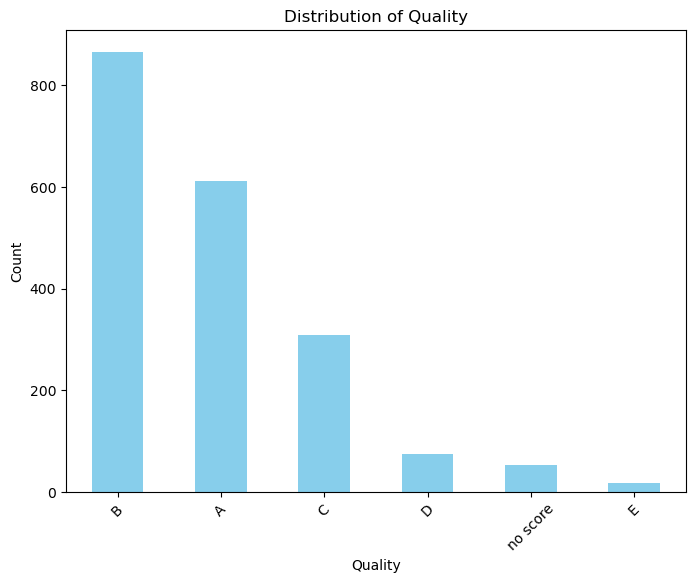

In [74]:
plot_bar_chart(bird_data_filtered, 'Quality')

To ensure we are getting quality data, we can drop any rows that have no score or a score lower than C.

In [75]:
bird_data_filtered = bird_data.loc[bird_data['Quality'].isin(['A', 'B', 'C'])]

In [76]:
check_column_unique_values(bird_data_filtered, "Time")

Unique values for Time: ['7:48' '12:00' '11:00' '6:00' '13:00' '10:00' '7:43' '12:47' '12:45'
 '7:00' '?' '8:29' '15:00' '9:01' '7:19' '20:31' '15:34' '11:19' '7:23'
 '17:00' '7:40' '17:30' '15:27' '17:50' '21:18' '21:53' '21:05' '8:00'
 '11:30' '15:20' '13.5' '8:30' '6:35' '5:56' '6:15' 'am' '15:30' '5:35'
 '9:30' '6:12' '8:10' '8:04' '6:45' '6:43' '14:39' '7:52' '14:45' '14:18'
 '8:53' '13:01' '11:41' '11:40' '11:39' '7:44' '7:32' '8:59' '9:38' '9:34'
 '10:35' '12:30' '7:30' '10:30' '11:45' '10:29' '7:12' '7:11' '19:00'
 '18:04' '12:39' '13:50' '13:25' '15:37' '8:25' '7:50' '11:35' '11:29'
 '9:28' '9:00' '20:50' '21:16' '21:15' '6:57' '14:00' '13.58' '5:30pm'
 '9:58' '?:?' '14:30' '5:42pm' '10:45' '5:40' '23:30' '6:52' '8:27' '8:20'
 '9:40' '6:58' '10.34am' '8:46' '13.3' '16:49' '17:05' '6:30' '6:40'
 '6:24' '18:30' '18:00' '16:00' '16:50' '10:37' '0:00' '12:10' '13:20'
 '6:38' '6:39' '16:30' '9:33' '15:50' '18:20' 'xx:xx' '16:11' '6:28'
 '11:15' '13:33' '6:50' '17:31' '17:04' '17:03

The time column is very messy, where some time includes AM and PM, or just says morning, early morning or dawn. We can clean this column by removing the AM/PM and converting the time to a 24 hour format. We can also round the time to the nearest hour to make it easier to work with.

In [77]:
def convert_non_standard_time(time_str):
    time_str = time_str.lower()

    time_mapping = {
        'dawn': '05:00',
        'early morning': '07:00',
        'morning': '09:00',
        'am': '11:00',
        'pm': '13:00'
    }
    
    if re.match(r'\b(?:morning|dawn|early morning|am|pm)\b', time_str):
        return time_mapping.get(time_str, '?')

    return time_str

In [78]:
def convert_to_24_hour_format(time_str):
    time_str = time_str.lower()

    # Handle time formats like "9.30am" or "9:30 am"
    time_str = time_str.replace(".", ":")  # Replace dot with colon to standardize format

    # Use regular expressions to extract hour and minute components
    match = re.match(r'(\d{1,2}):?(\d{0,2})\s*(am|pm)?', time_str)
    if match:
        hour = int(match.group(1))
        minute = int(match.group(2)) if match.group(2) else 0
        period = match.group(3)

        if period == 'pm' and hour != 12:
            hour += 12
        elif period == 'am' and hour == 12:
            hour = 0

        # Round the minutes to the closest hour
        if minute >= 30:
            hour += 1

        # Format the time in 24-hour format (00:00)
        return f'{hour:02d}:00'
    
    #print(f'Invalid time format: {time_str}')
    return '?'

In [79]:
bird_data_filtered['Time'] = bird_data_filtered['Time'].apply(convert_non_standard_time)
bird_data_filtered['Time'] = bird_data_filtered['Time'].apply(convert_to_24_hour_format)

check_column_unique_values(bird_data_filtered, "Time")

Unique values for Time: ['08:00' '12:00' '11:00' '06:00' '13:00' '10:00' '07:00' '?' '15:00'
 '09:00' '21:00' '16:00' '17:00' '18:00' '22:00' '14:00' '19:00' '24:00'
 '00:00' '03:00' '05:00' '20:00' '04:00' '02:00' '01:00' '23:00']


/tmp/ipykernel_387/580187137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['Time'] = bird_data_filtered['Time'].apply(convert_non_standard_time)
/tmp/ipykernel_387/580187137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['Time'] = bird_data_filtered['Time'].apply(convert_to_24_hour_format)


In [80]:
def get_time_of_day(time):
    if time == '?':
        return '?'
    else:
        hour = int(time.split(":")[0])
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 18:
            return 'afternoon'
        else:
            return 'evening'

In [81]:
bird_data_filtered['time_of_day'] = bird_data_filtered['Time'].apply(get_time_of_day)

/tmp/ipykernel_387/1790315602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['time_of_day'] = bird_data_filtered['Time'].apply(get_time_of_day)


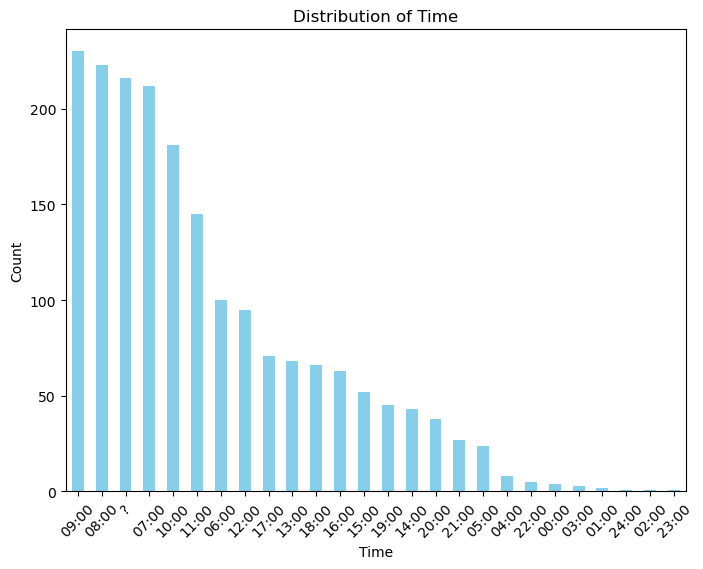

In [82]:
plot_bar_chart(bird_data_filtered, 'Time')

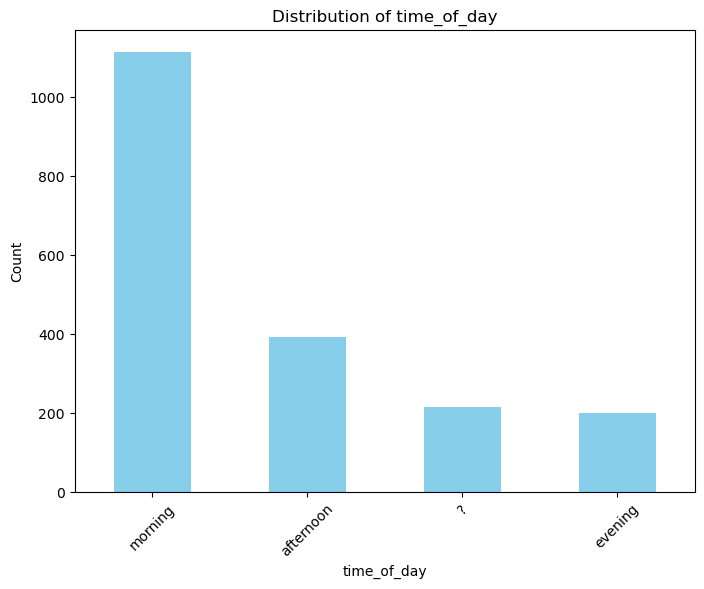

In [83]:
plot_bar_chart(bird_data_filtered, 'time_of_day')

In [84]:
check_column_unique_values(bird_data_filtered, "Date")

Unique values for Date: ['6/7/2017' '2/8/2018' '3/10/2018' ... '6/4/2009' '6/7/2007' '4/19/2007']


To make it easier to work with the date column, we can more columns such as month, day, and year.

In [85]:
def convert_to_standard_date(date_str):
    date_formats = [
        '%m/%d/%Y',    # 05/04/2012
        '%Y-%m-%d',    # 2009-06-00
        '%m/%d/%Y',    # 5/4/2012 (Single-digit month and day)
        '%m/%d/%y',    # 5/4/12 (Single-digit month and day with two-digit year)
        '%m-%d-%Y',    # 5-4-2012 (Single-digit month and day with hyphens)
        '%Y-%m-%d %H:%M:%S',    # 2009-06-00 00:00:00 (DateTime format with time)
        '%m/%d/%Y %H:%M:%S',    # 5/4/2012 00:00:00 (DateTime format with time)
    ]

    for date_format in date_formats:
        try:
            date_obj = pd.to_datetime(date_str, format=date_format)
            return date_obj.strftime('%m/%d/%Y')
        except ValueError:
            pass

    # Return None if the date cannot be parsed with any of the formats
    return None

In [86]:
def extract_date_components(date_str):
    if pd.isnull(date_str):
        return pd.Series({'Month': -1, 'Day': -1, 'Year': -1})
    
    date_regex = r'(\d{1,2})/(\d{1,2})/(\d{2,4})'
    match = re.match(date_regex, date_str)
    if match:
        month, day, year = map(int, match.groups())
        return pd.Series({'Month': month, 'Day': day, 'Year': year})
    else:
        return pd.Series({'Month': -1, 'Day': -1, 'Year': -1})

In [87]:
bird_data_filtered['Date'] = bird_data_filtered['Date'].apply(convert_to_standard_date)

/tmp/ipykernel_387/3851628704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['Date'] = bird_data_filtered['Date'].apply(convert_to_standard_date)


In [88]:
check_column_unique_values(bird_data_filtered, "Date")

Unique values for Date: ['06/07/2017' '02/08/2018' '03/10/2018' ... '06/04/2009' '06/07/2007'
 '04/19/2007']


In [89]:
date_components = bird_data_filtered['Date'].apply(extract_date_components)
bird_data_filtered[['Month', 'Day', 'Year']] = date_components

/tmp/ipykernel_387/1536665120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered[['Month', 'Day', 'Year']] = date_components
/tmp/ipykernel_387/1536665120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered[['Month', 'Day', 'Year']] = date_components
/tmp/ipykernel_387/1536665120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [90]:
bird_data_filtered['Month'] = bird_data_filtered['Month'].astype(int)
bird_data_filtered['Day'] = bird_data_filtered['Day'].astype(int)
bird_data_filtered['Year'] = bird_data_filtered['Year'].astype(int)

/tmp/ipykernel_387/2427731122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['Month'] = bird_data_filtered['Month'].astype(int)
/tmp/ipykernel_387/2427731122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['Day'] = bird_data_filtered['Day'].astype(int)
/tmp/ipykernel_387/2427731122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

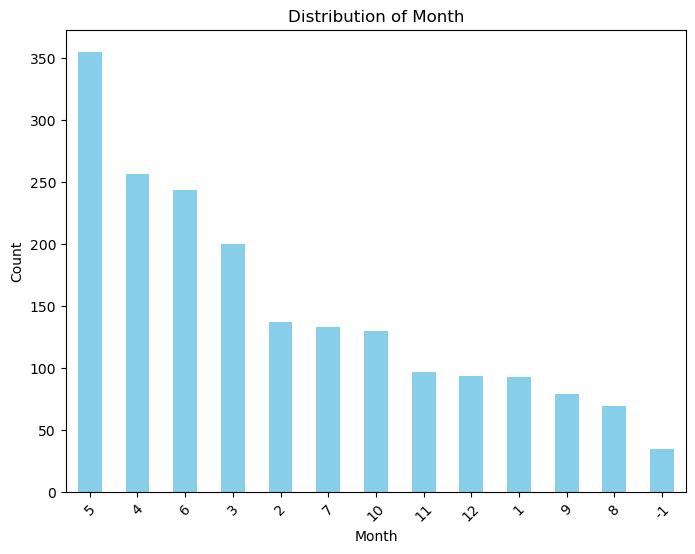

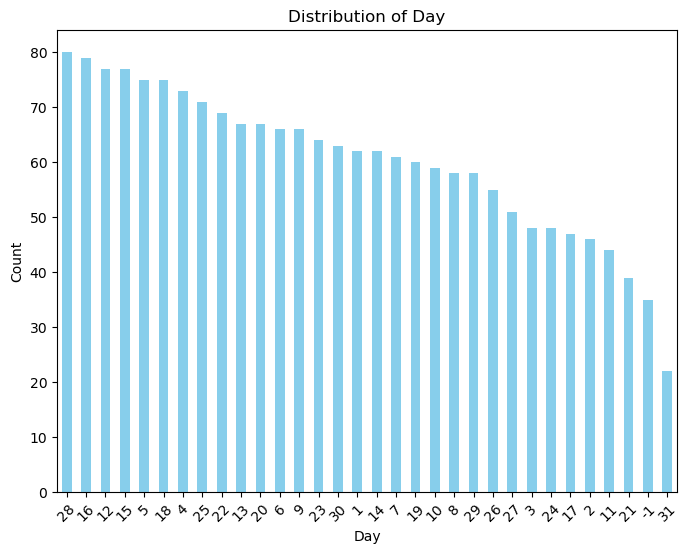

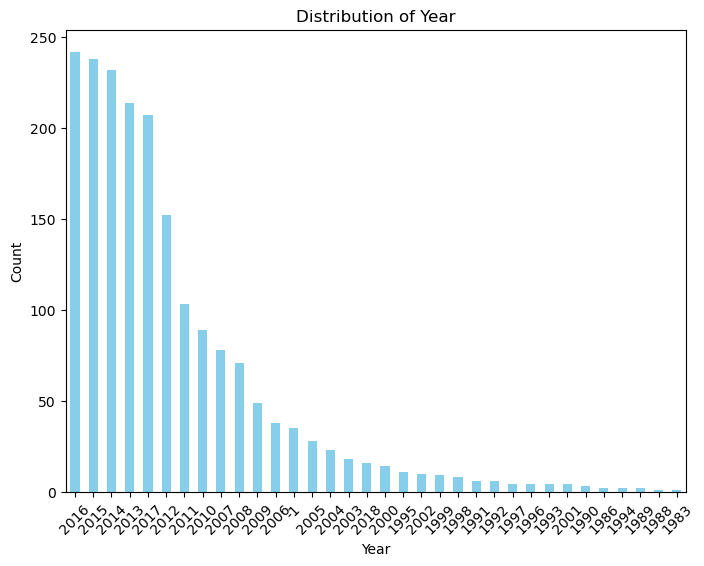

In [91]:
plot_bar_chart(bird_data_filtered, 'Month')
plot_bar_chart(bird_data_filtered, 'Day')
plot_bar_chart(bird_data_filtered, 'Year')

In [92]:
bird_data_filtered['Y'] = bird_data_filtered['Y'].astype(int)

/tmp/ipykernel_387/2102636524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['Y'] = bird_data_filtered['Y'].astype(int)


In [93]:
bird_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1924 entries, 1 to 2074
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   File ID            1924 non-null   int64 
 1   English_name       1924 non-null   object
 2   Vocalization_type  1924 non-null   object
 3   Quality            1924 non-null   object
 4   Time               1924 non-null   object
 5   Date               1889 non-null   object
 6   X                  1924 non-null   int64 
 7   Y                  1924 non-null   int64 
 8   time_of_day        1924 non-null   object
 9   Month              1924 non-null   int64 
 10  Day                1924 non-null   int64 
 11  Year               1924 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 195.4+ KB


In [94]:
def plot_coordinates_by_species(map_image, bird_data, year, species_col='English_name'):
    """
    Plots the coordinates on the map image and colors them based on the specified bird species.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(map_image)
    # create color list for each bird species
    color_list = sns.color_palette("tab20b", n_colors=len(bird_data[species_col].unique()))
    # create a color dictionary for each bird species
    color_dict = dict(zip(bird_data[species_col].unique(), color_list))
    # plot the coordinates on the map image
    for index, row in bird_data.iterrows():
        plt.scatter(row['X'], row['Y'], color=color_dict[row[species_col]], s=100)
    plt.title(f'Coordinates Colored by Bird Species - Year: {year}')
    # create a list of patches for the legend
    patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color_dict[i],
                label=i)[0]  for i in bird_data[species_col].unique()]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis('off')  # Turn off the axis
    plt.show()

In [95]:
bird_data_filtered['Year'].unique()

array([2017, 2018, 2008, 2016, 2000, 2015, 2014, 2013, 1993, 2012, 2009,
       2004, 2005, 1996, 2010, 2007, 2011, 1991, 2003, 1998,   -1, 1990,
       1992, 1997, 2006, 2002, 1999, 1988, 1986, 1994, 1989, 1983, 1995,
       2001])

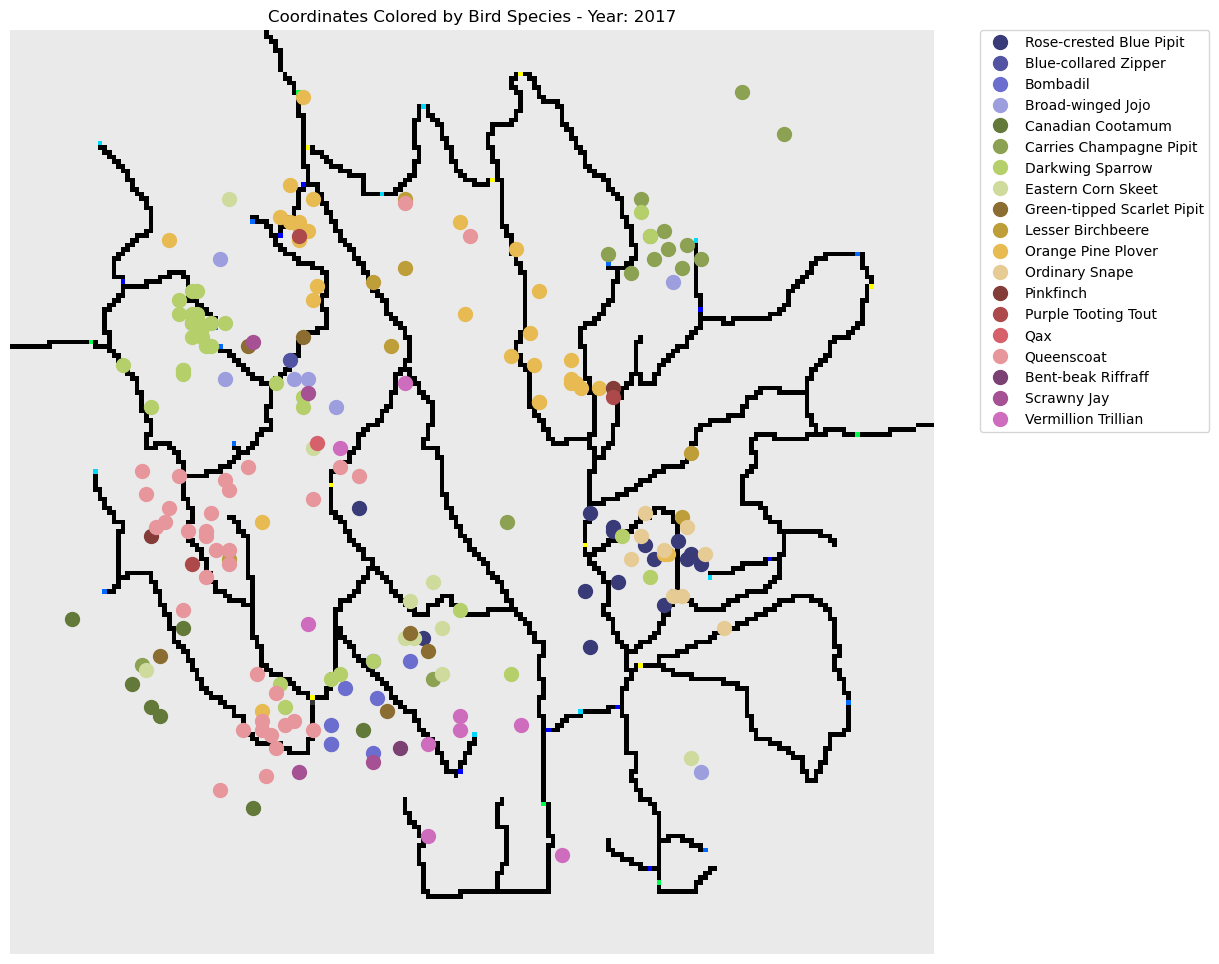

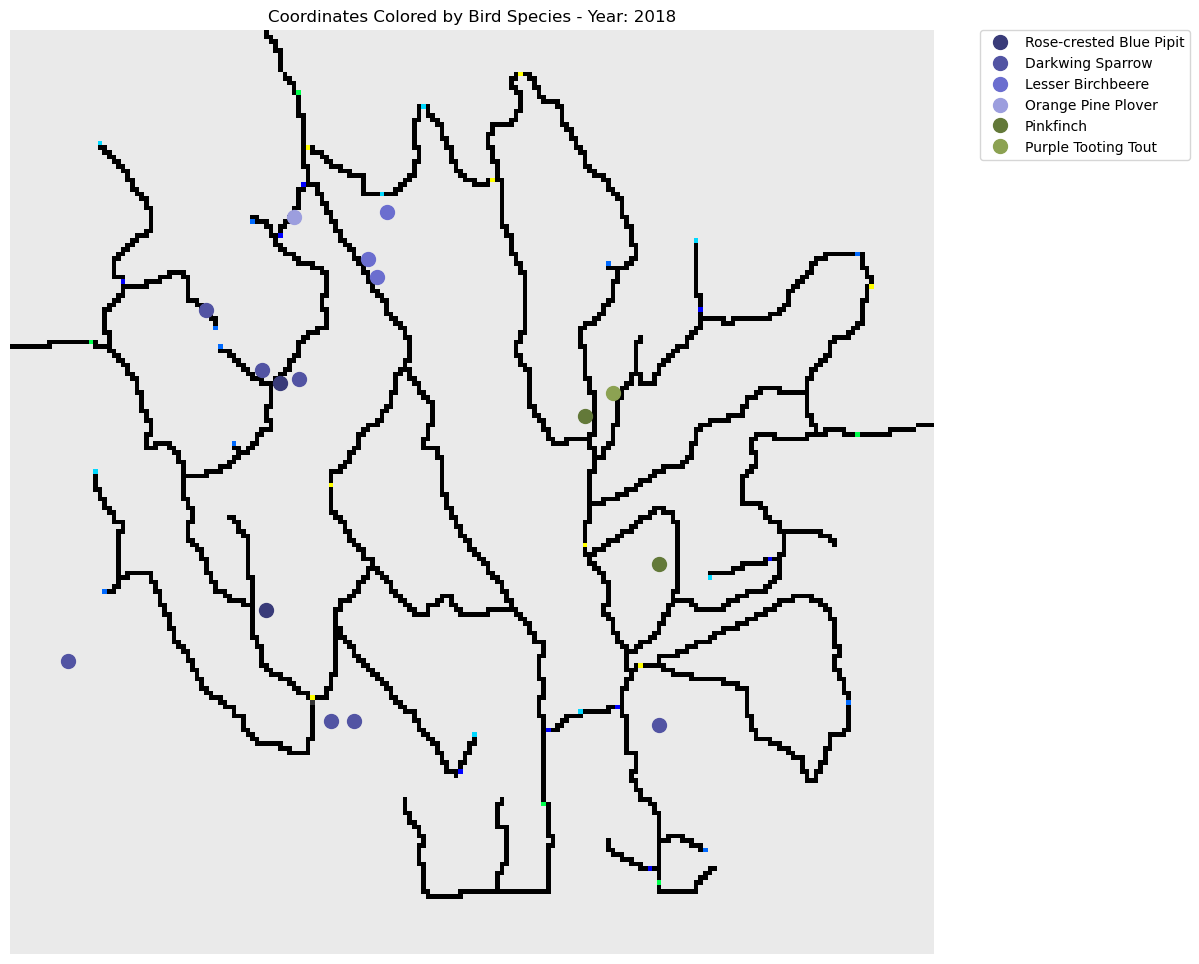

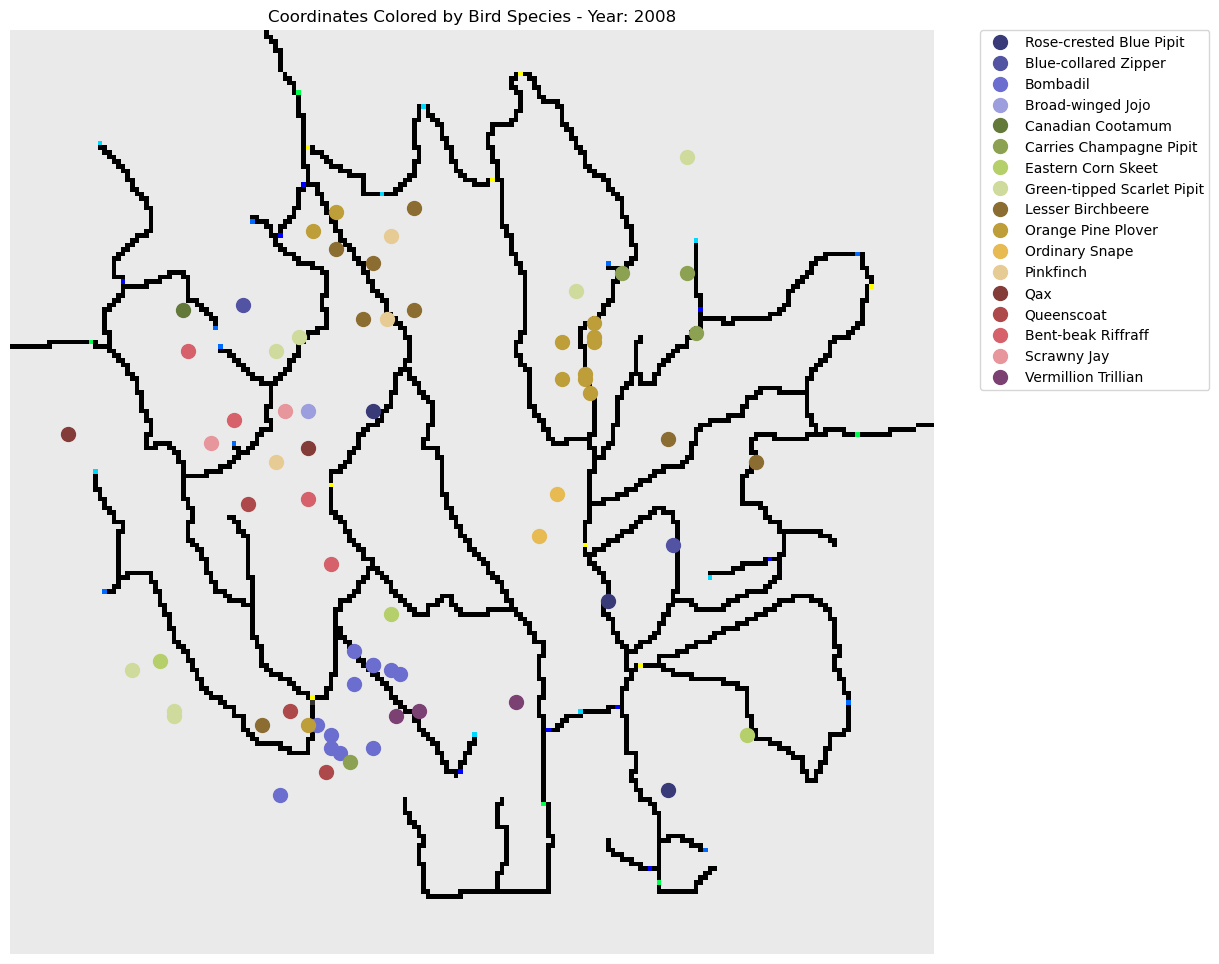

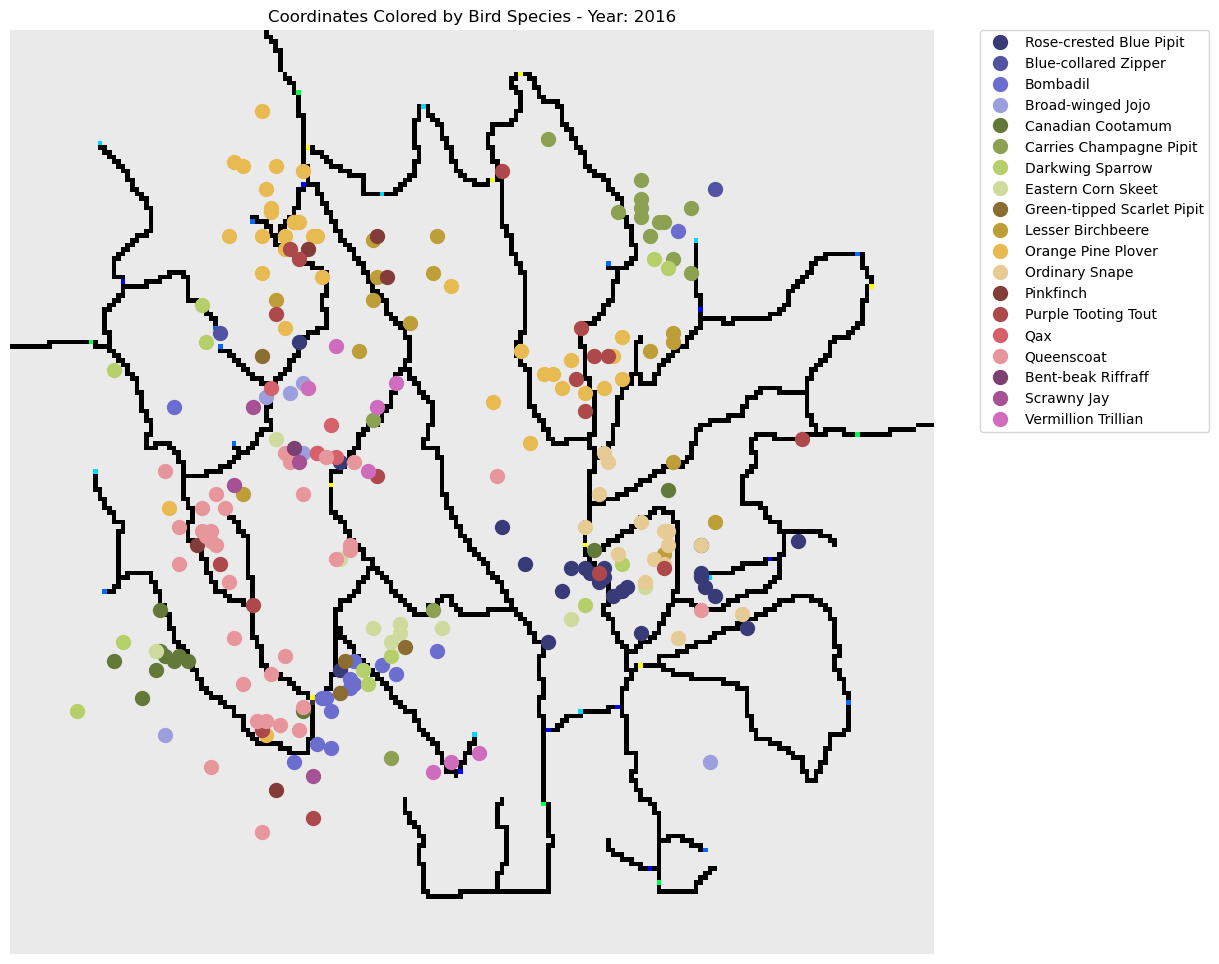

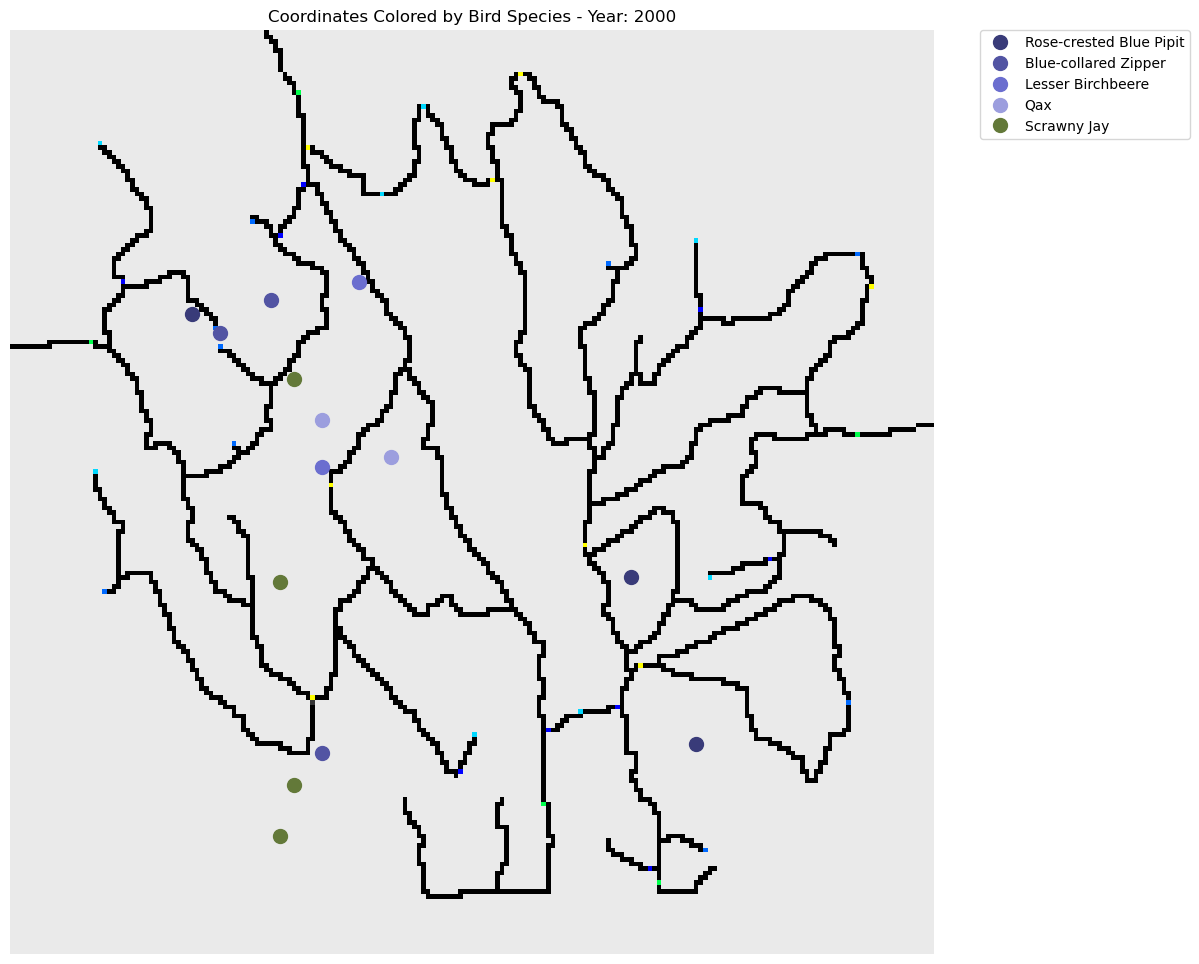

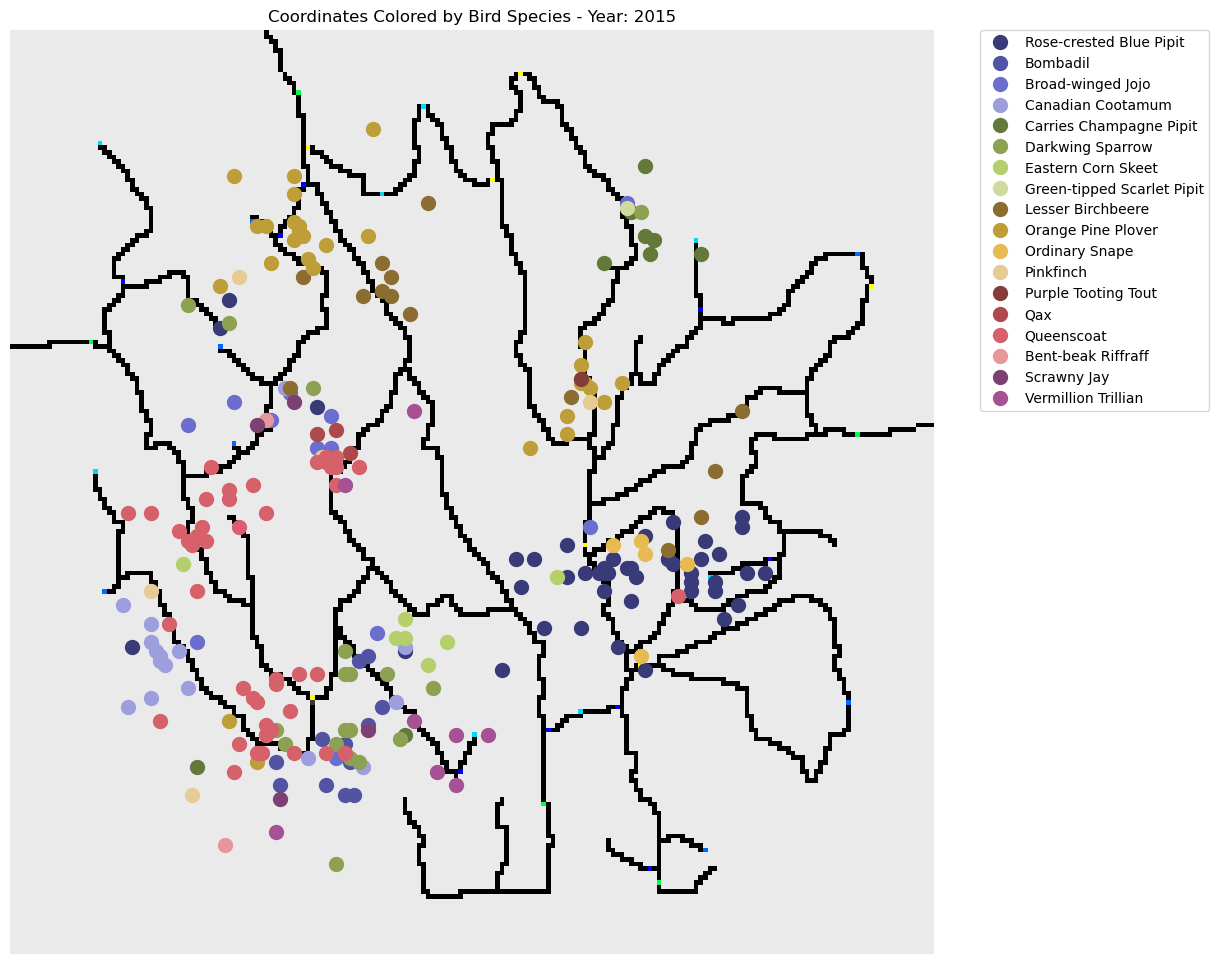

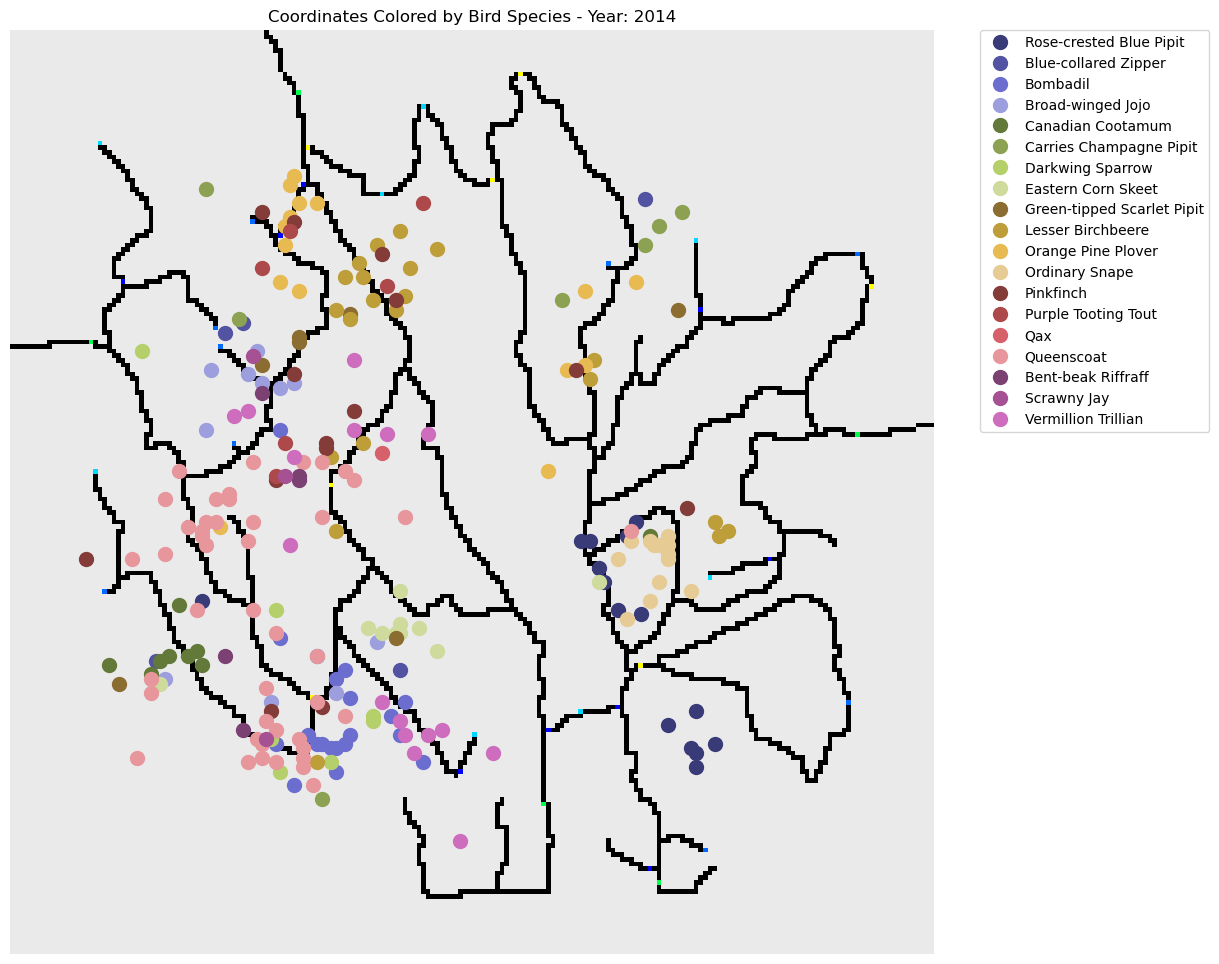

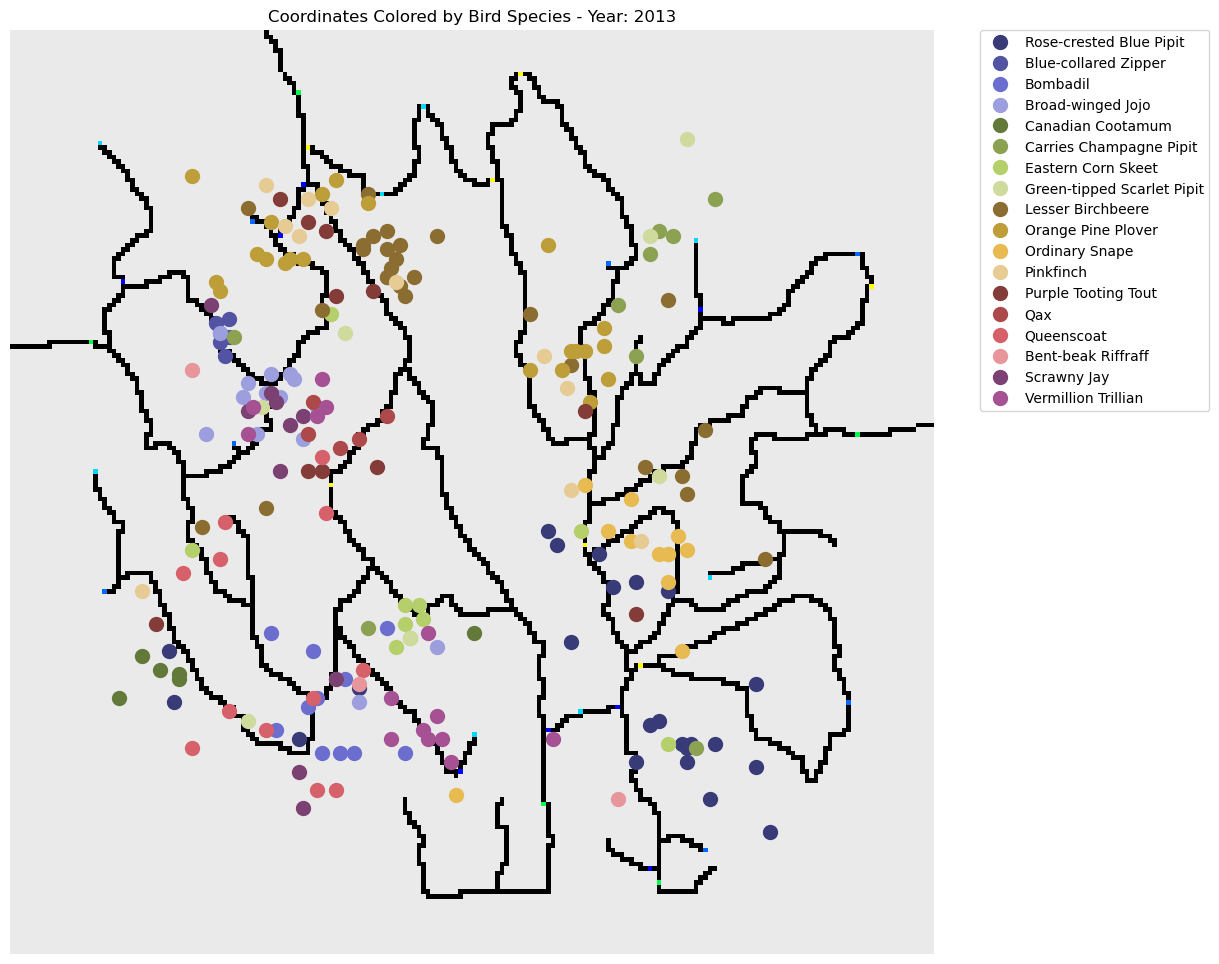

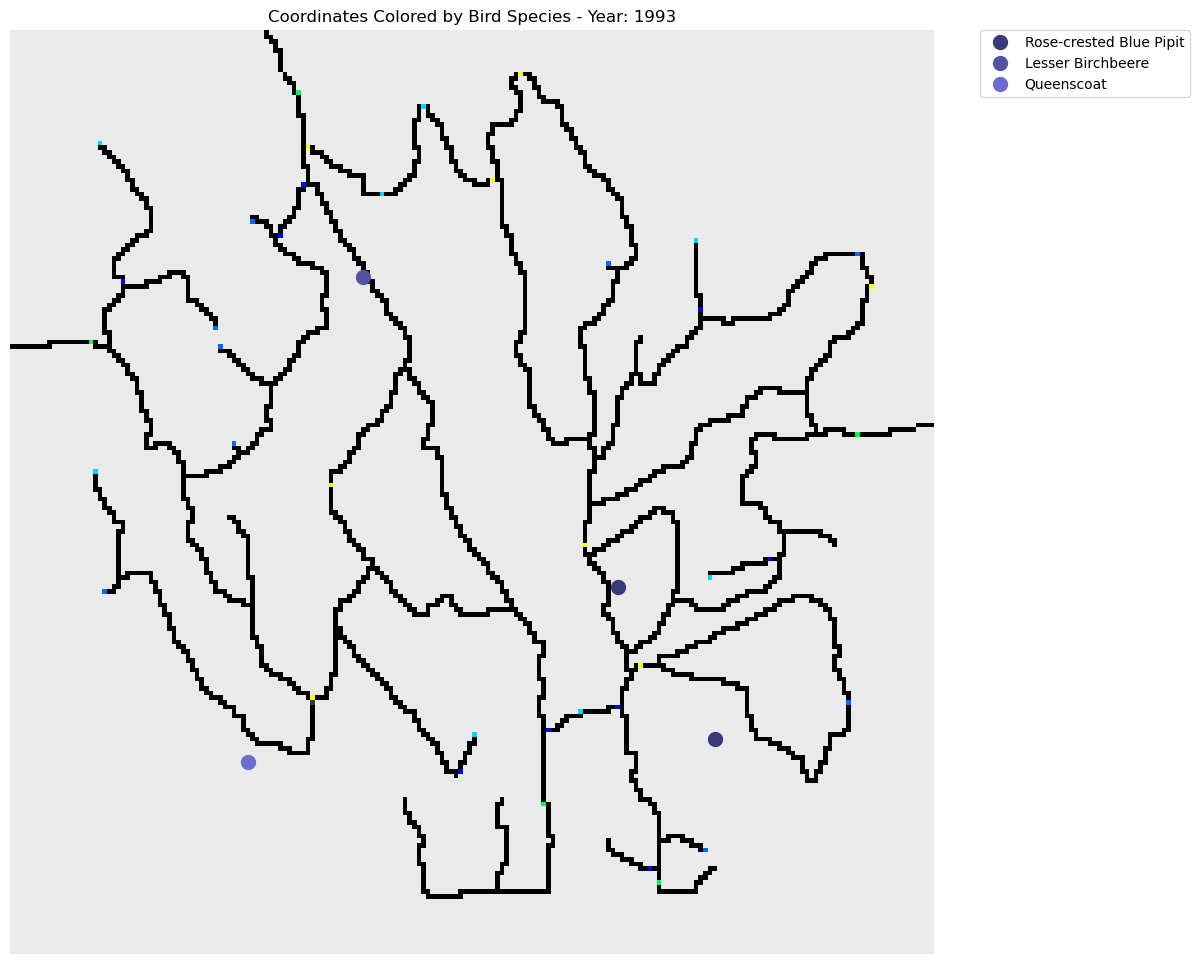

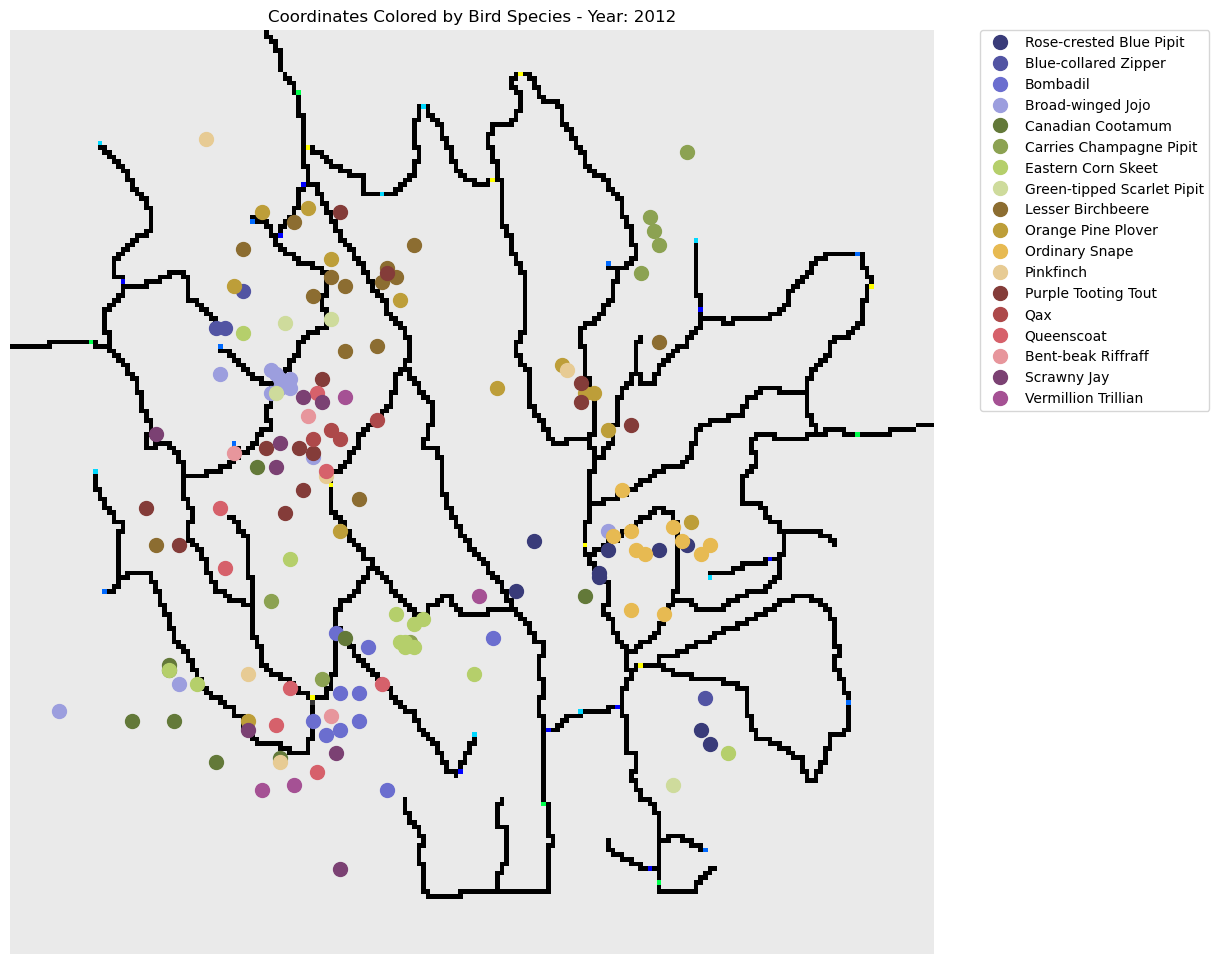

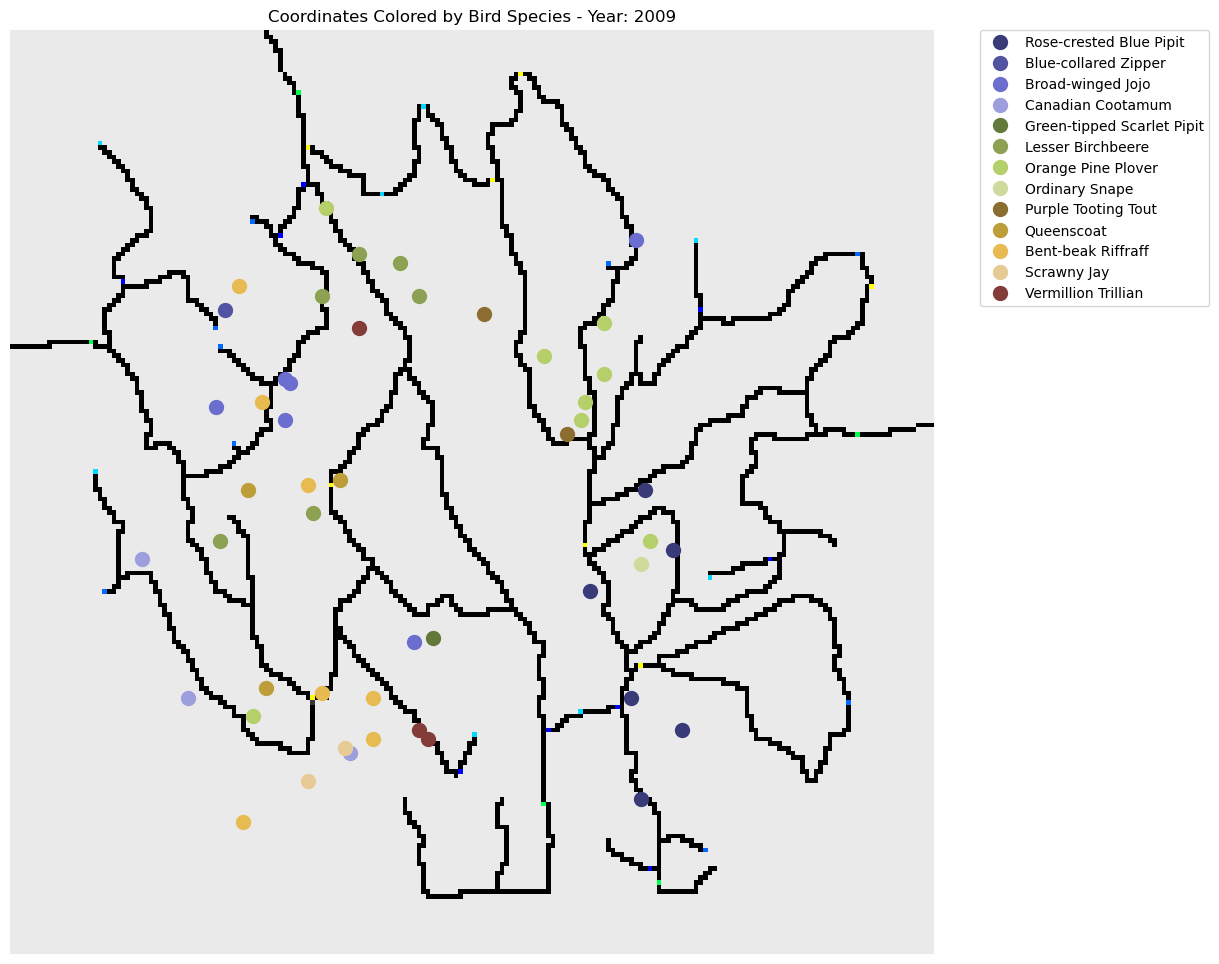

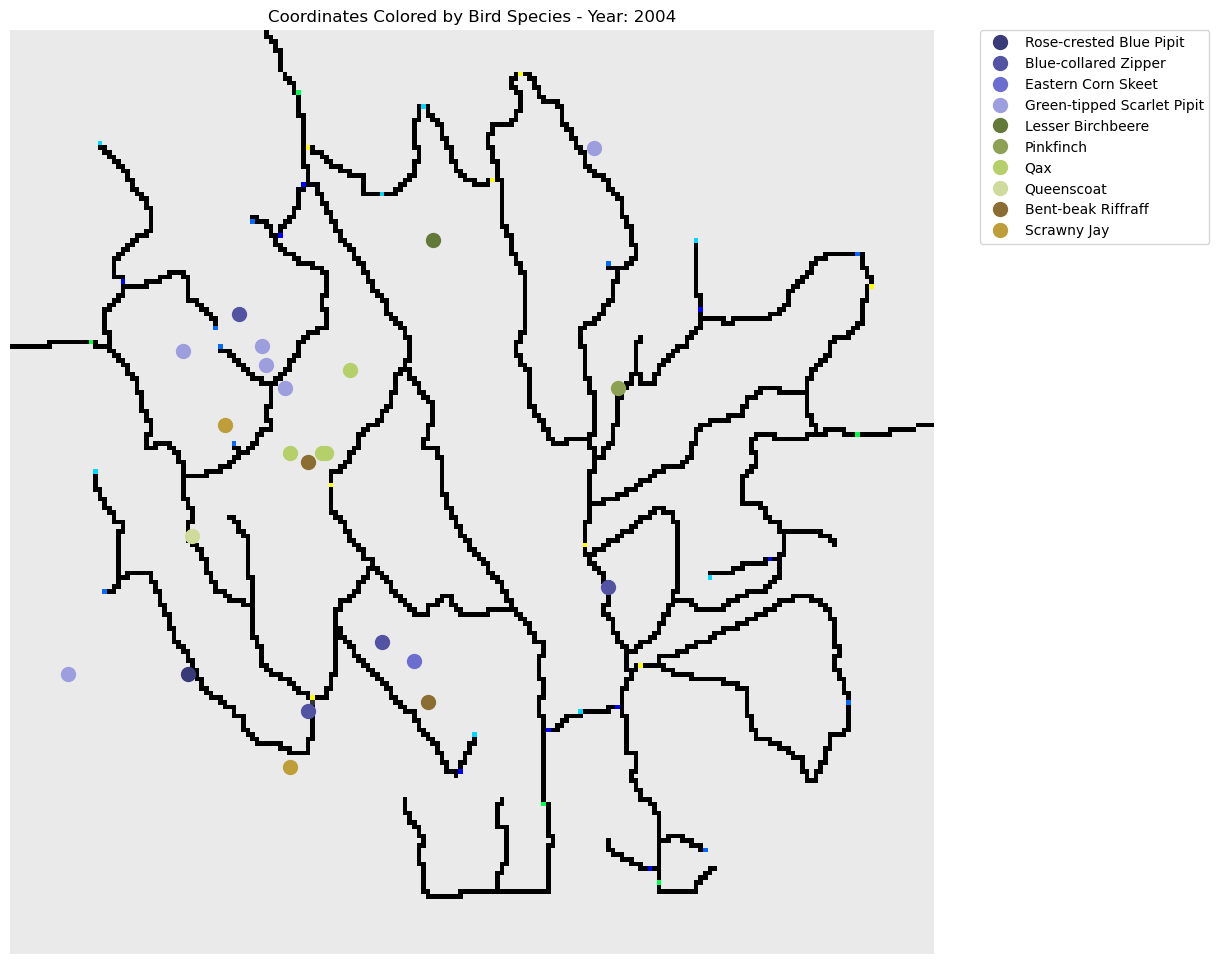

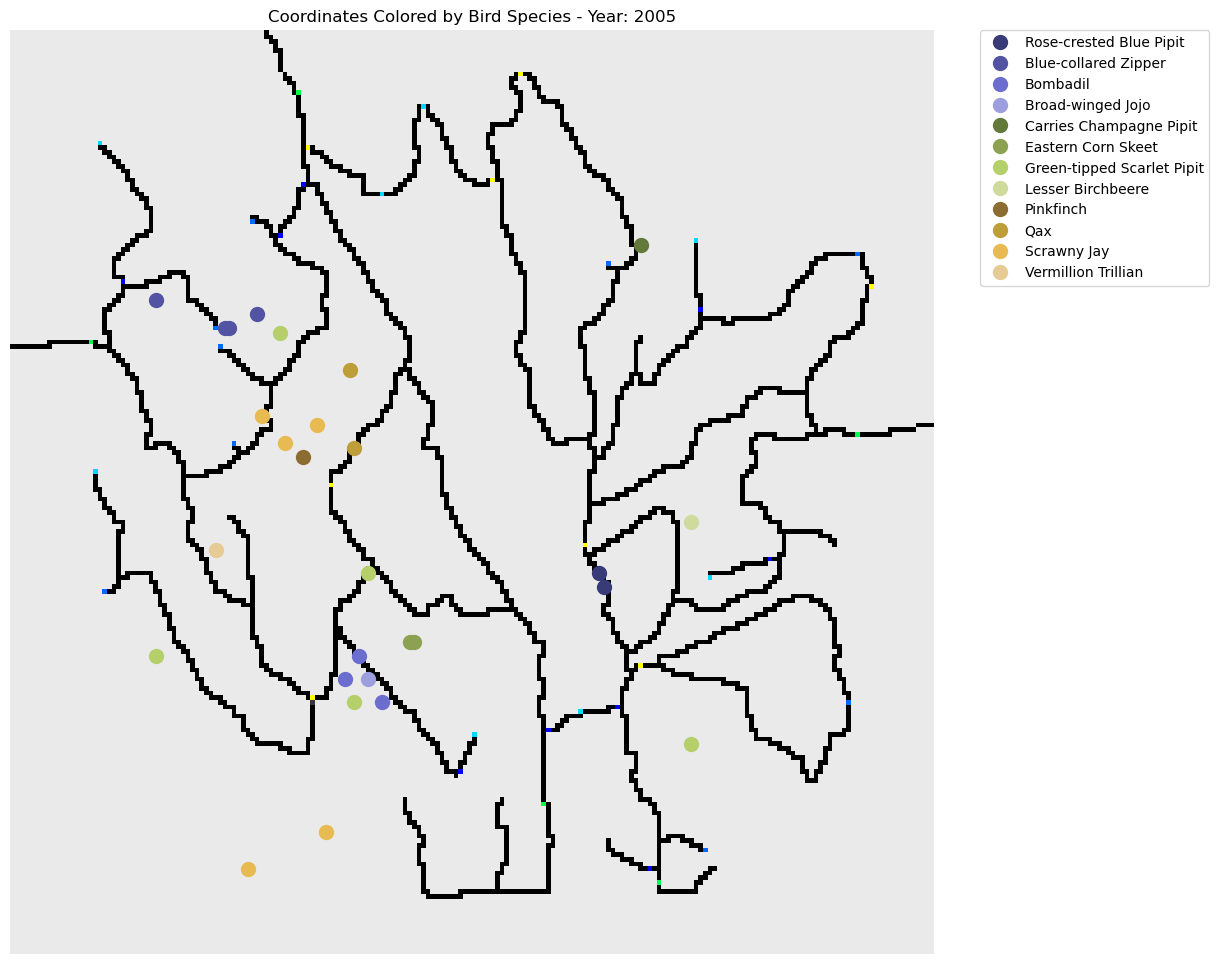

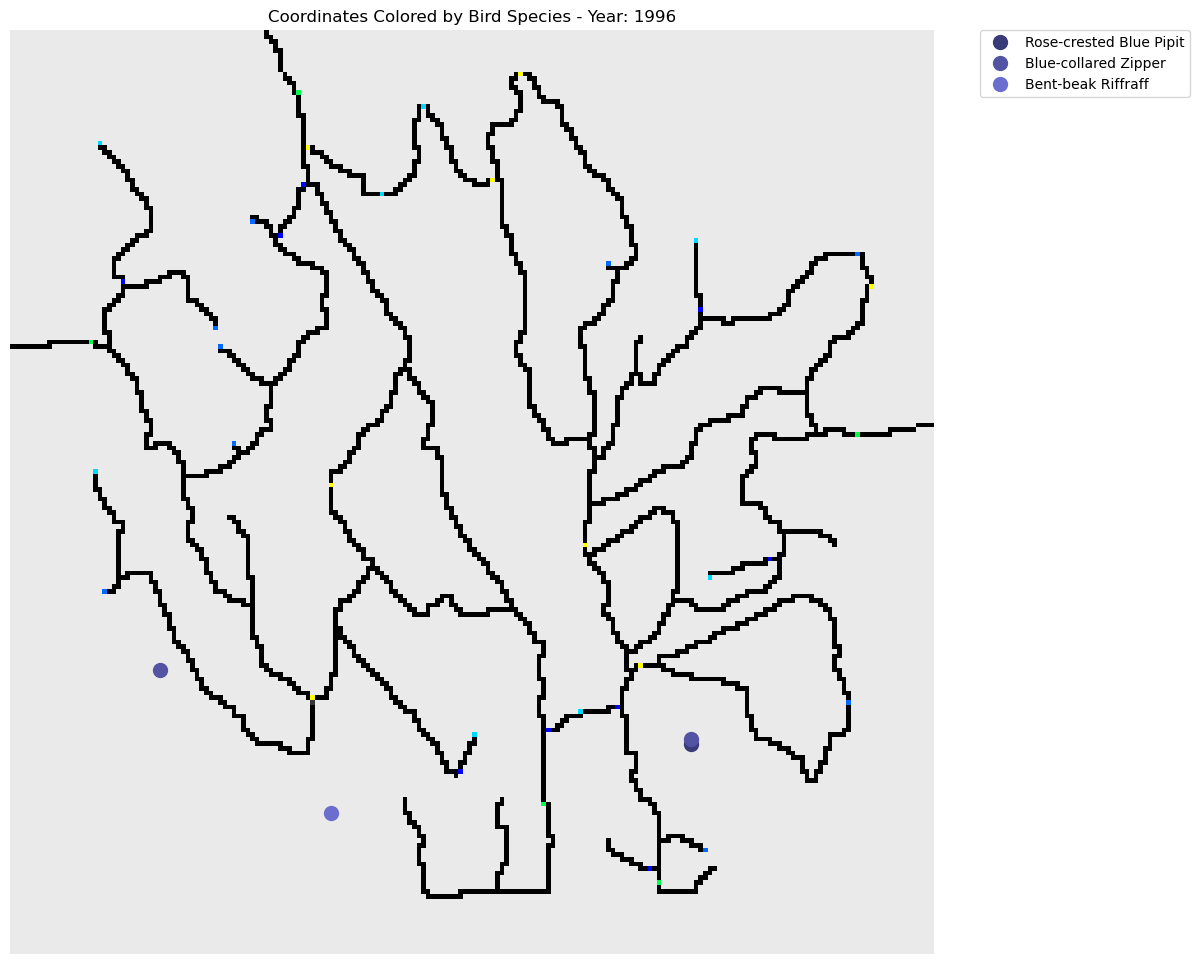

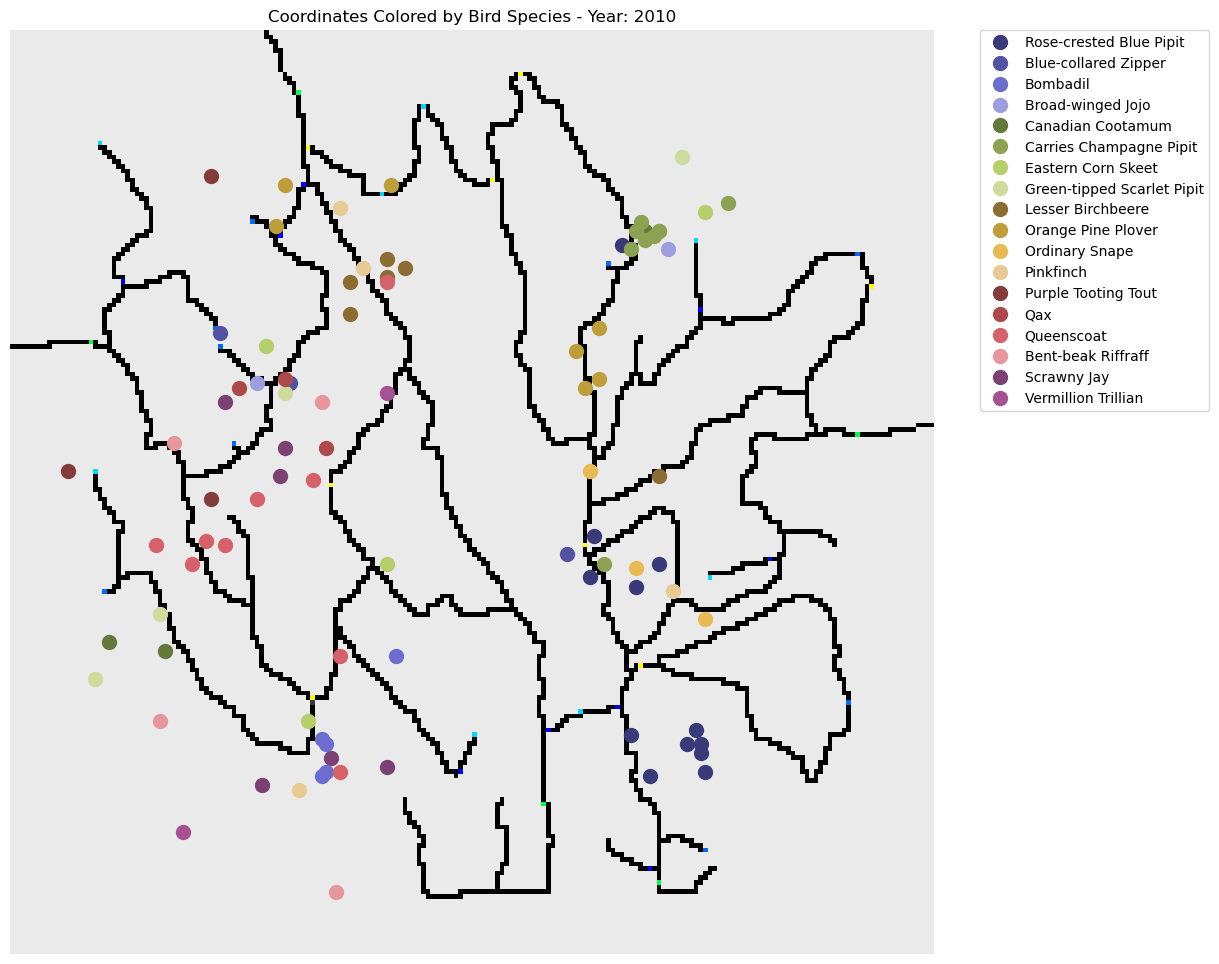

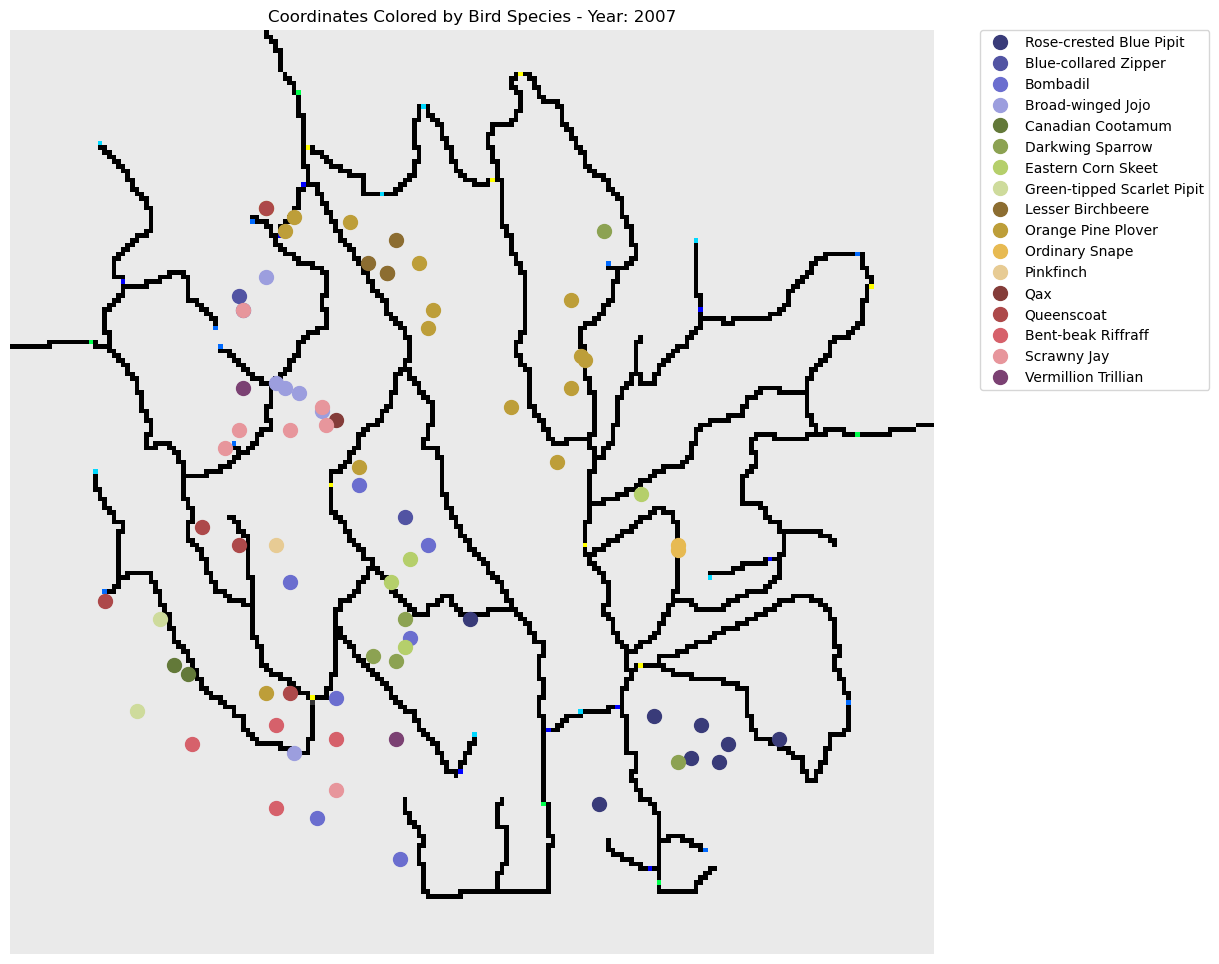

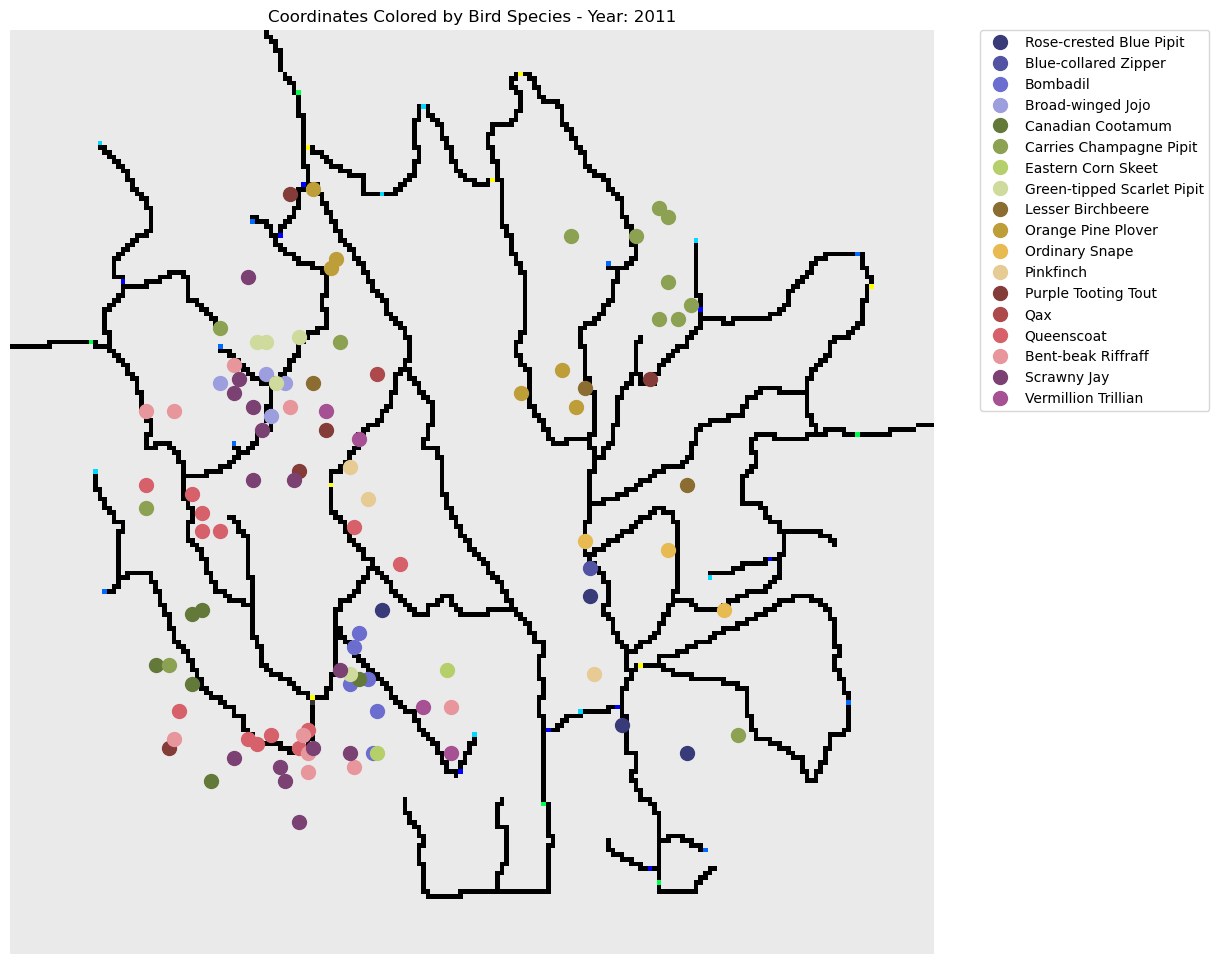

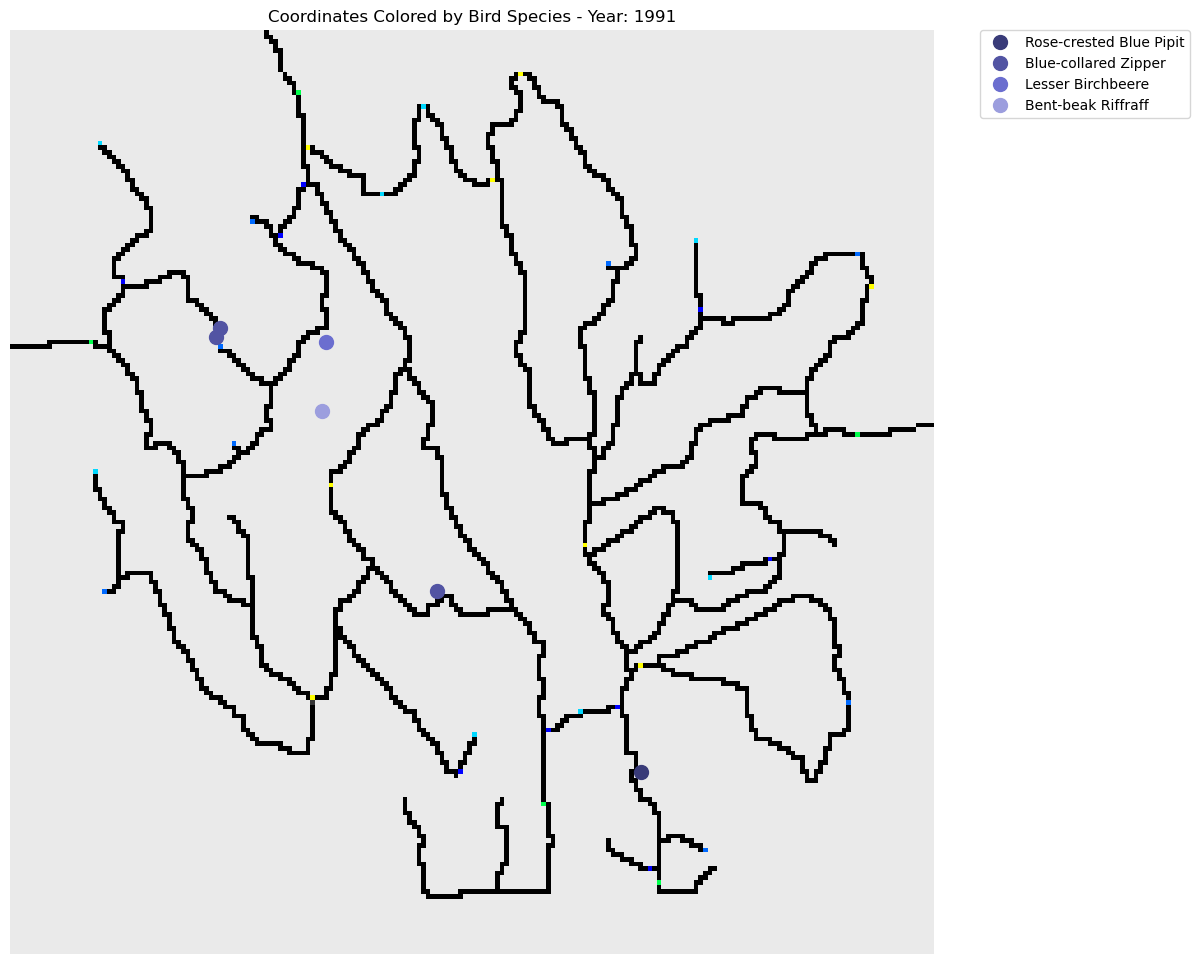

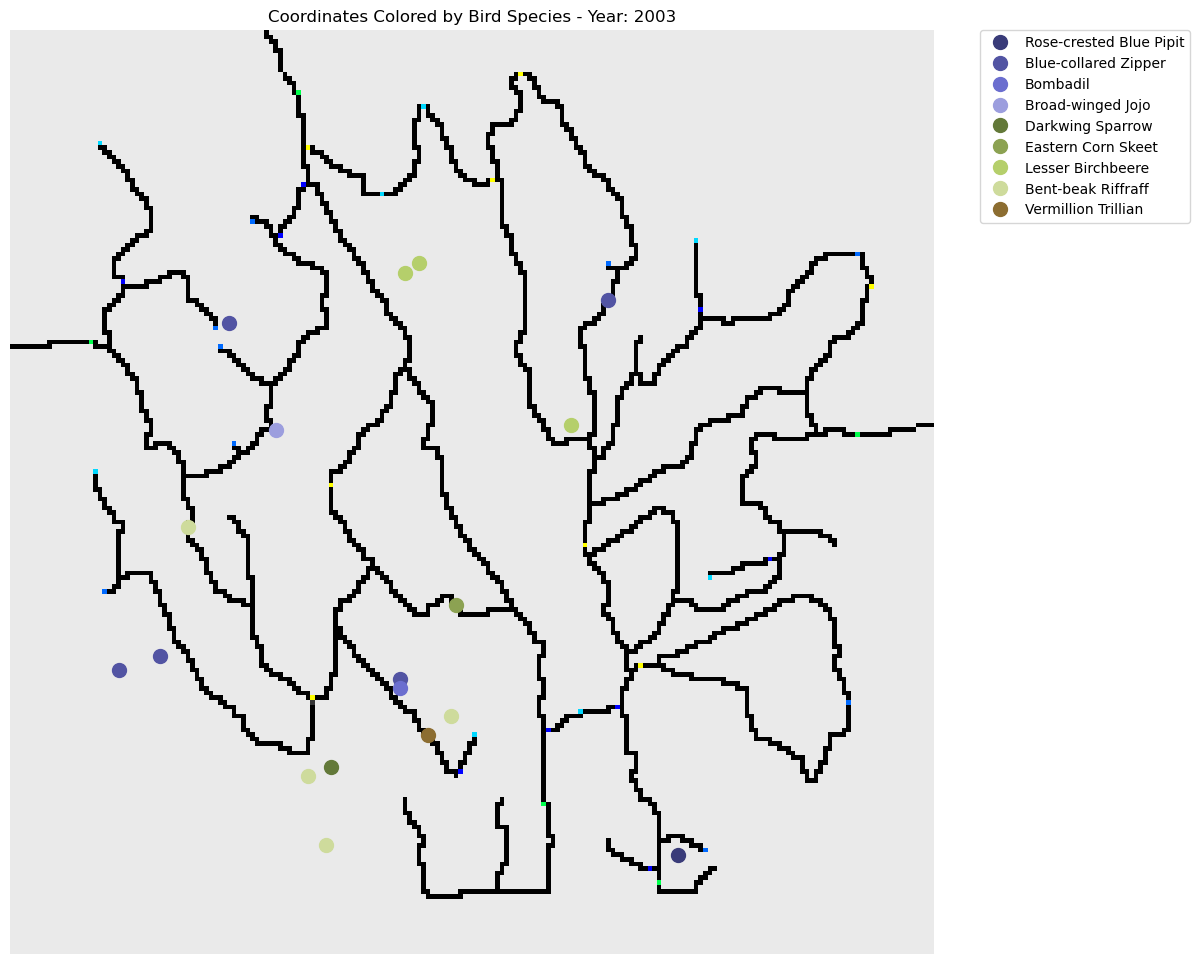

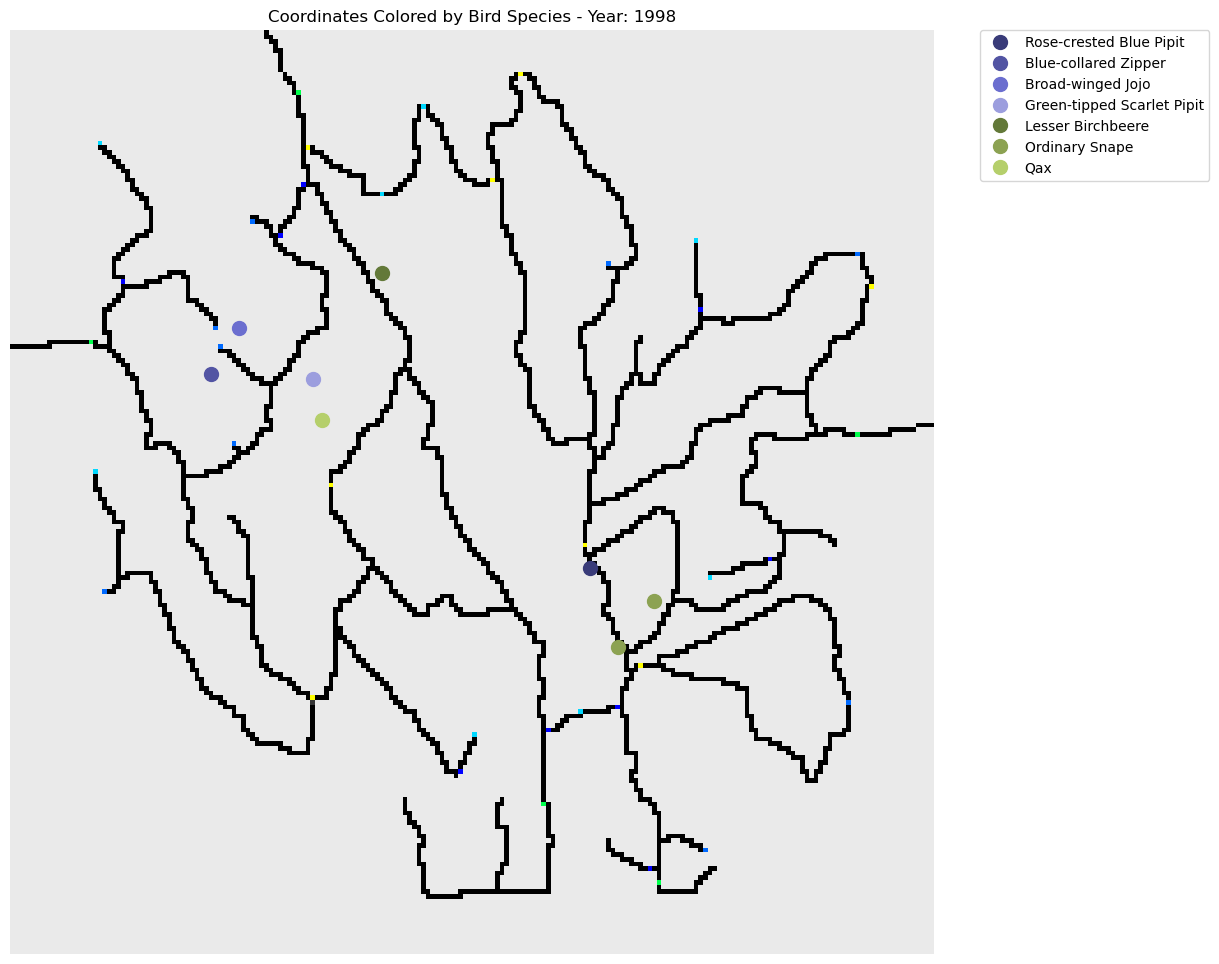

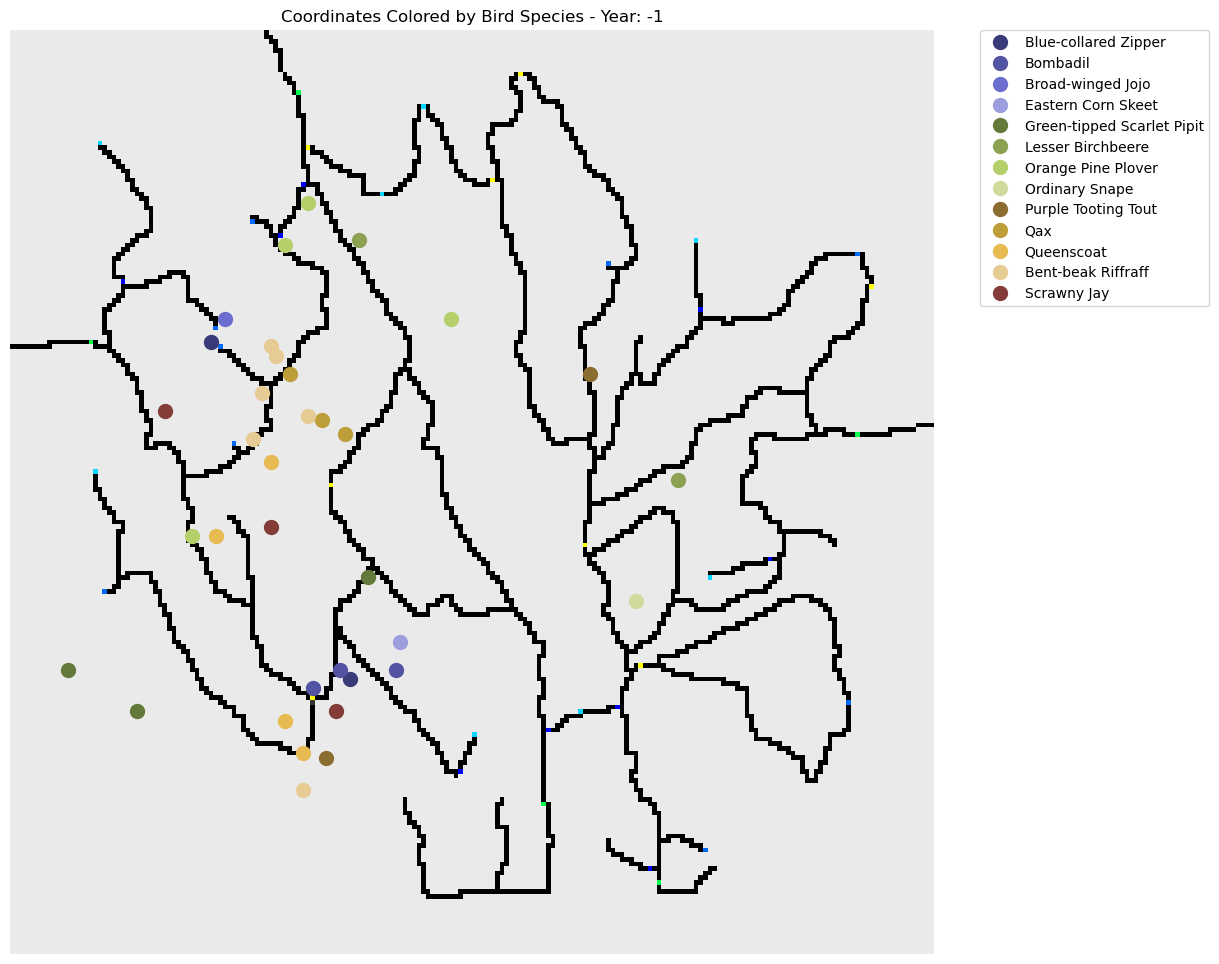

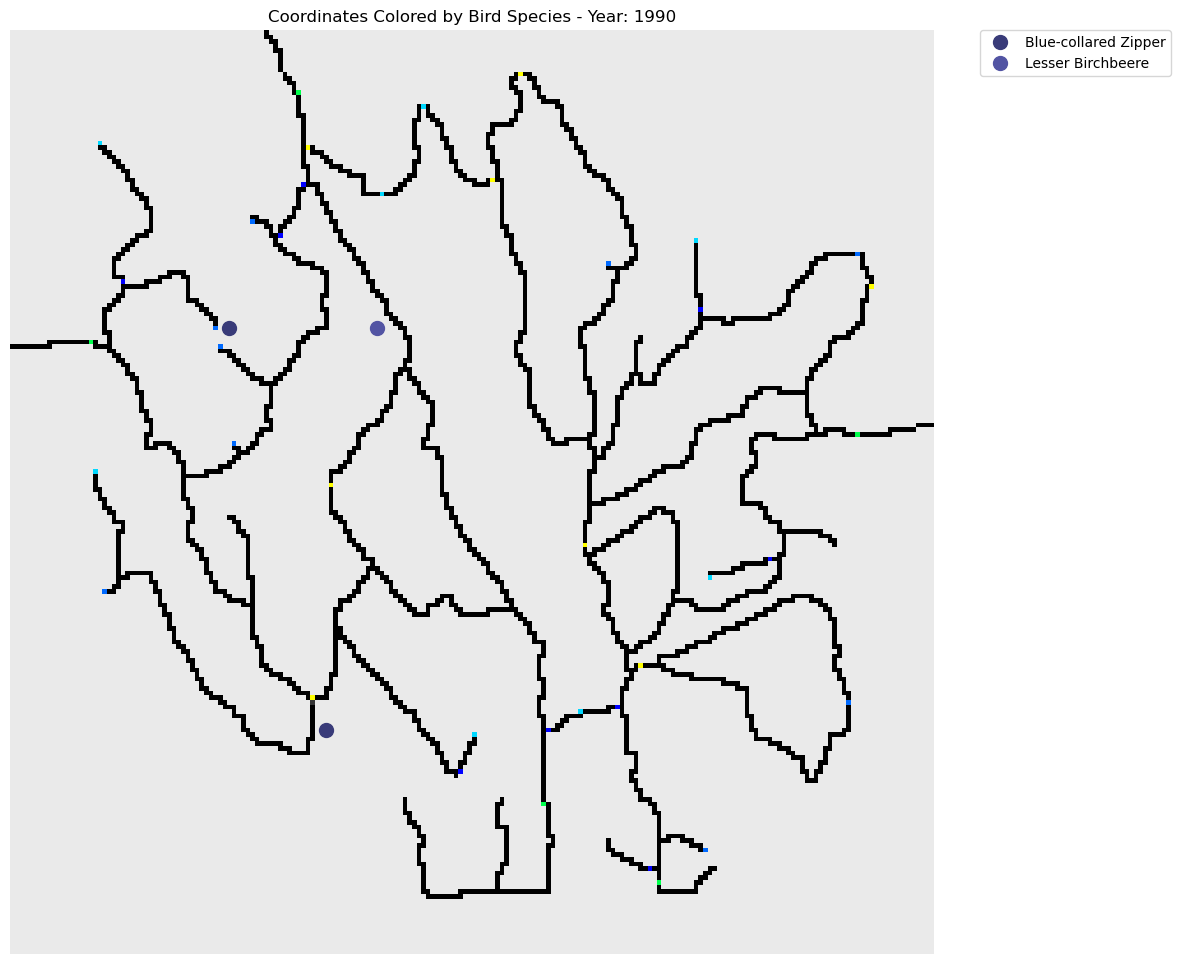

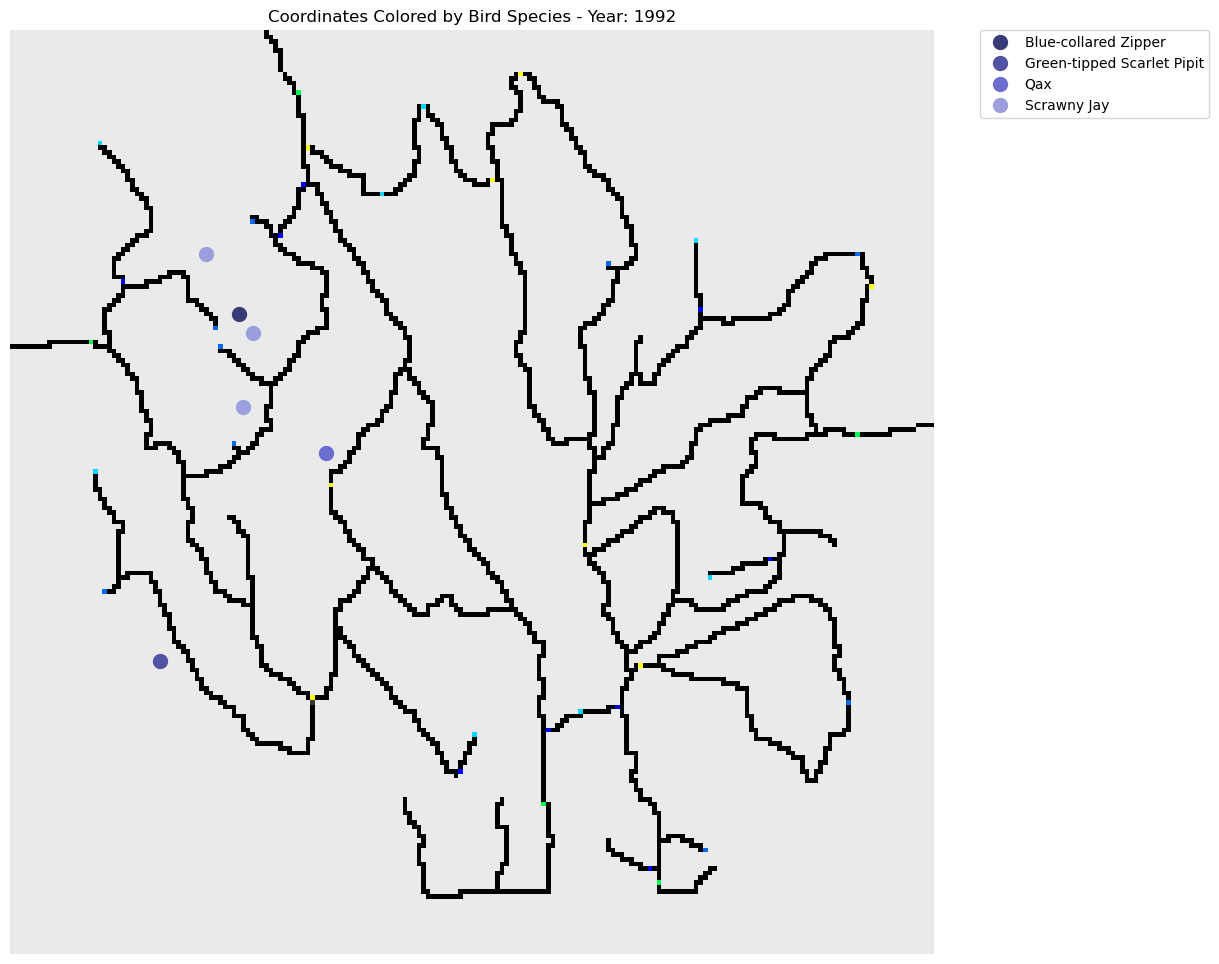

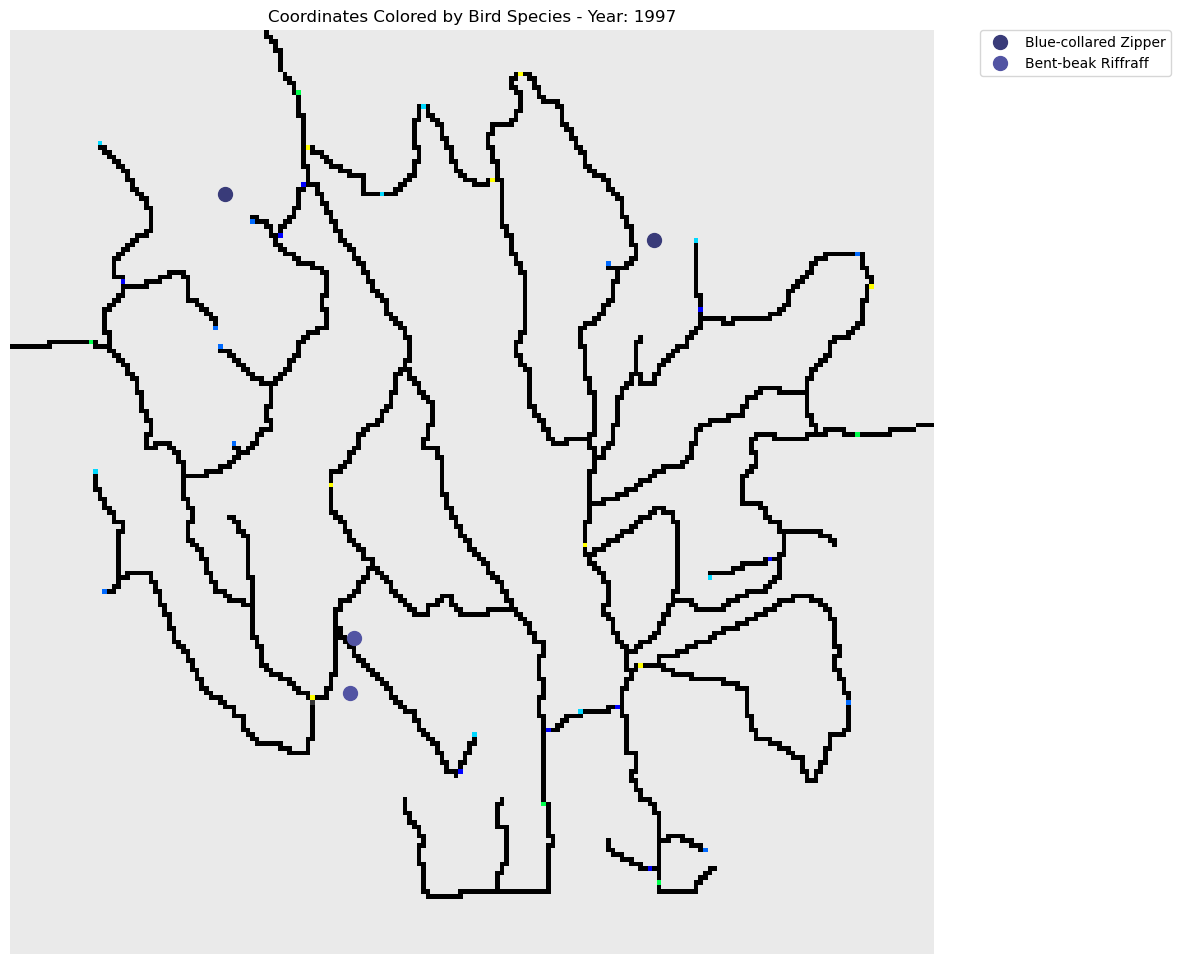

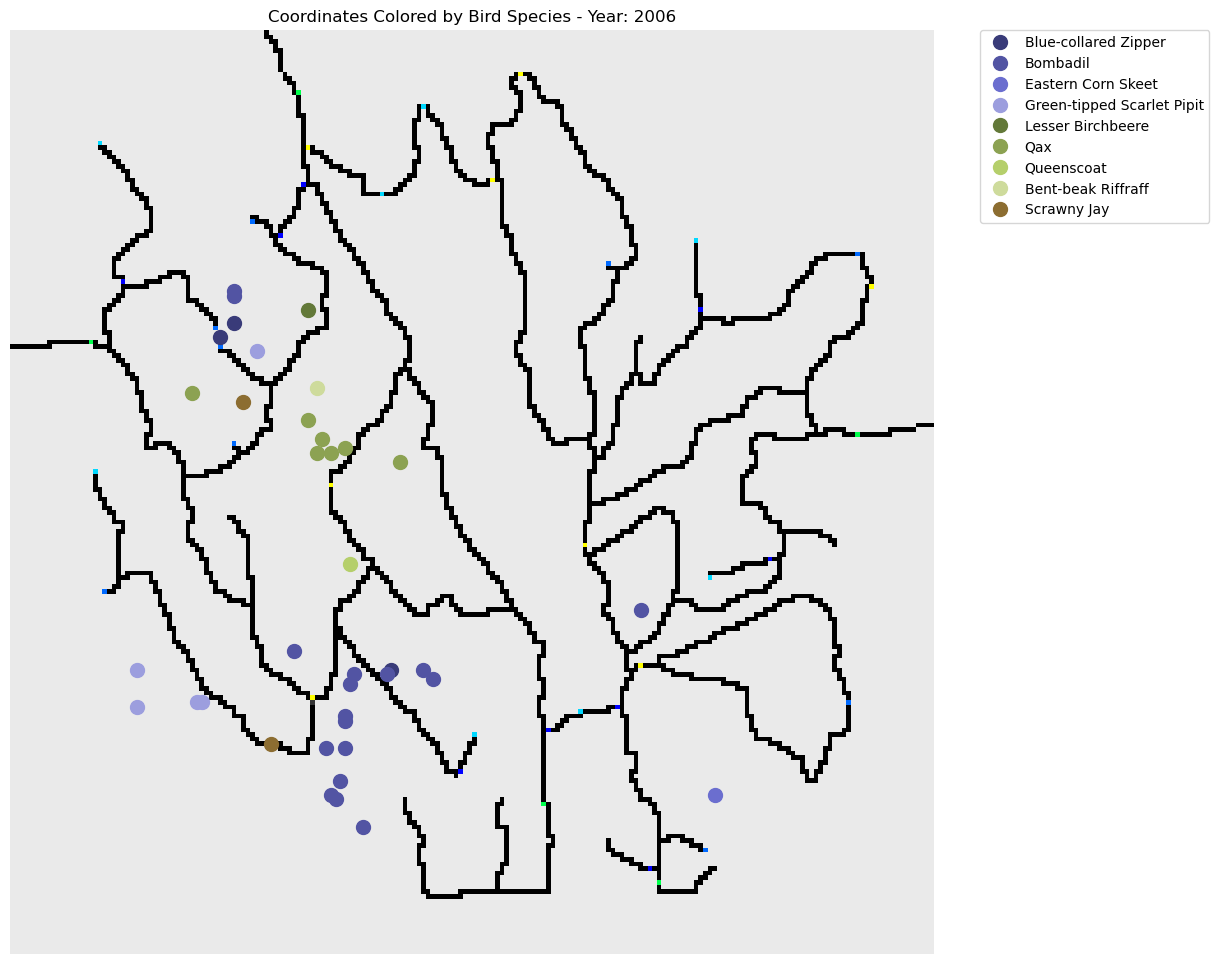

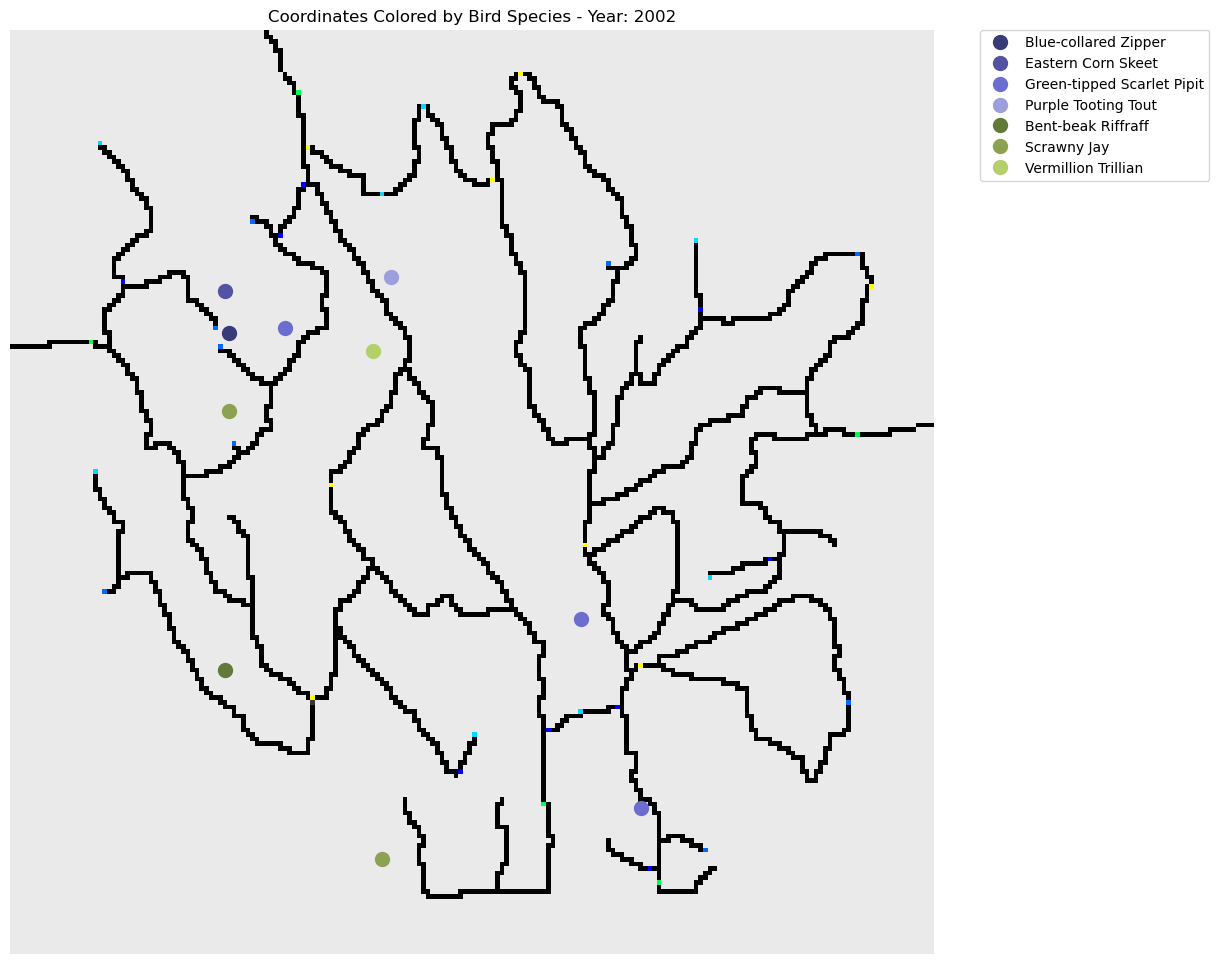

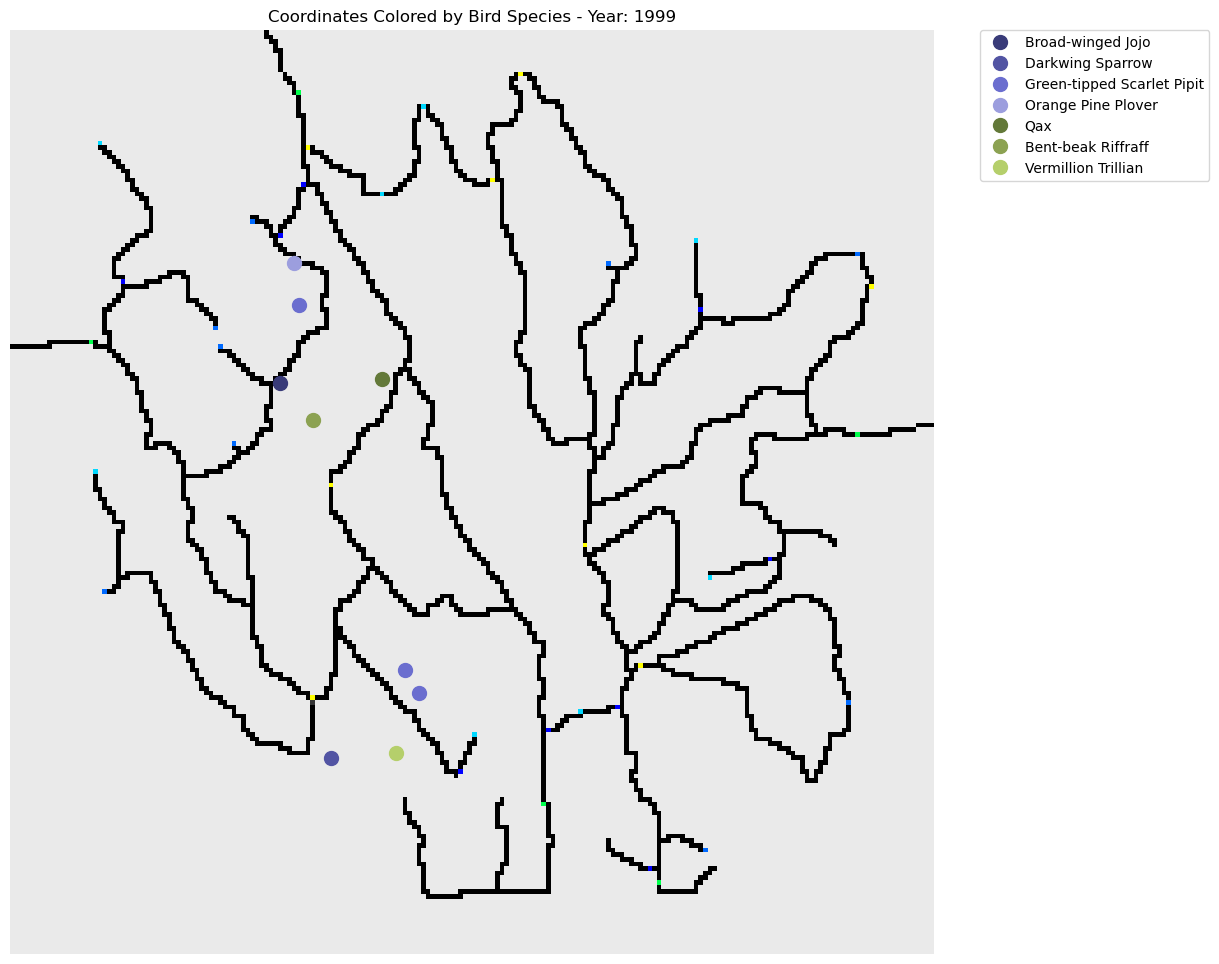

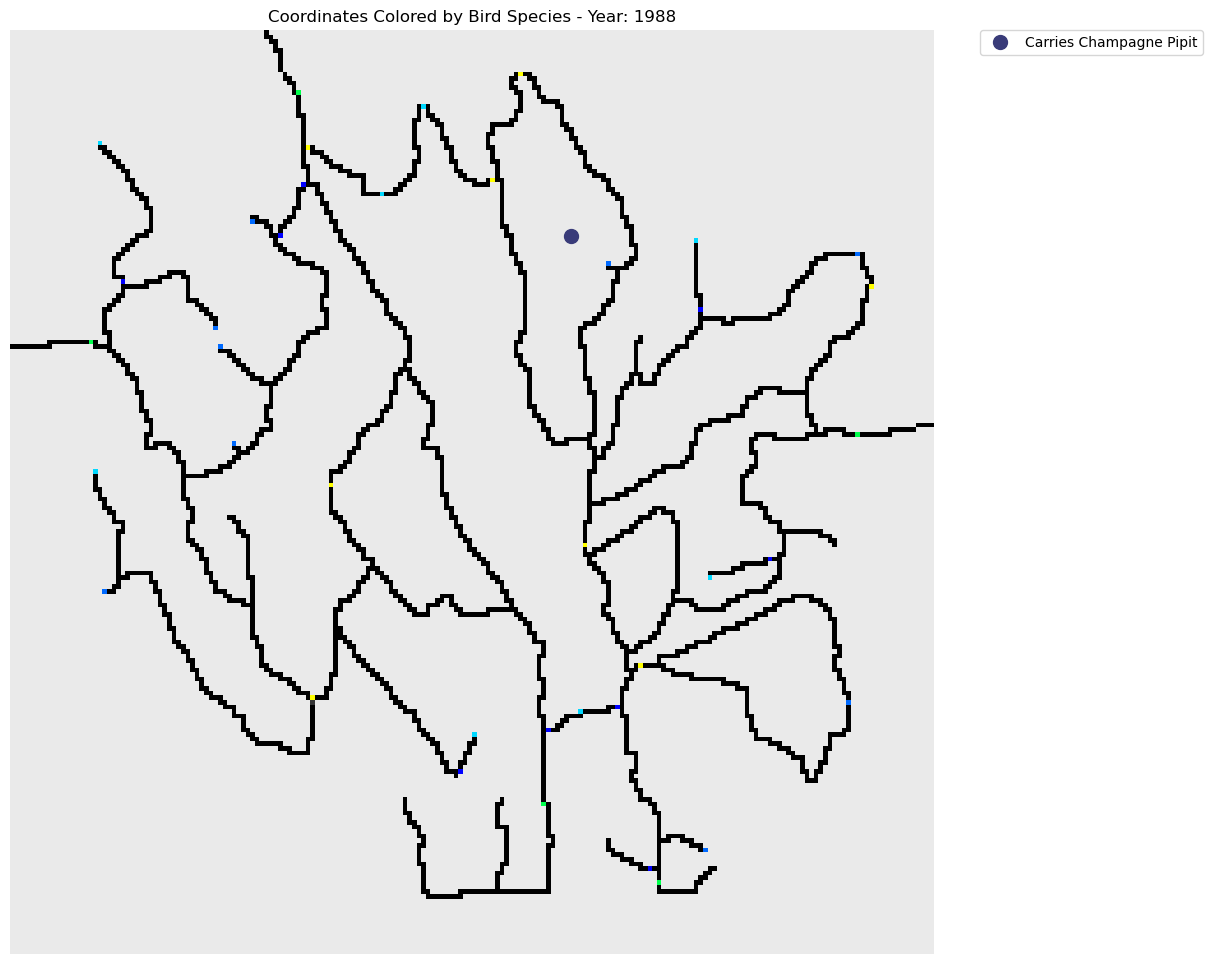

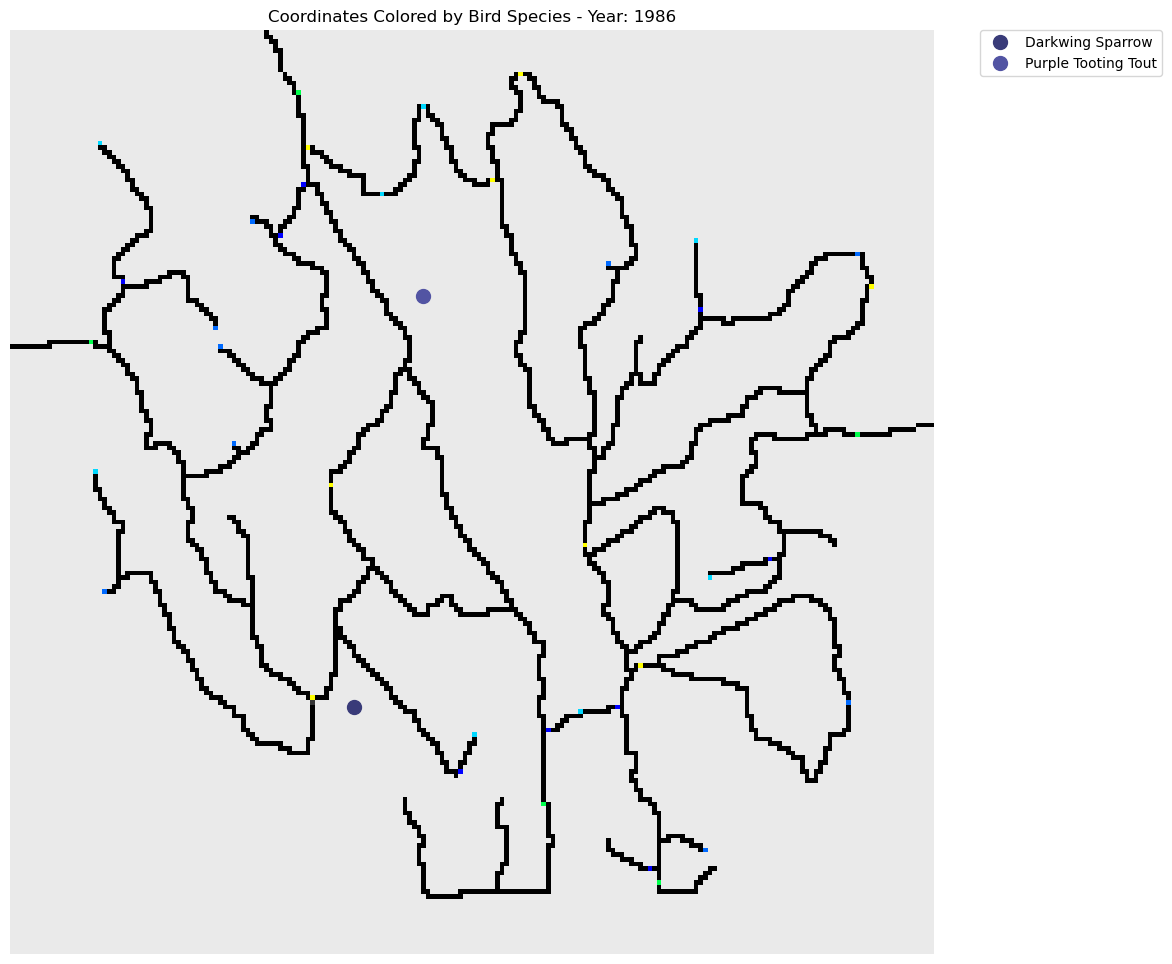

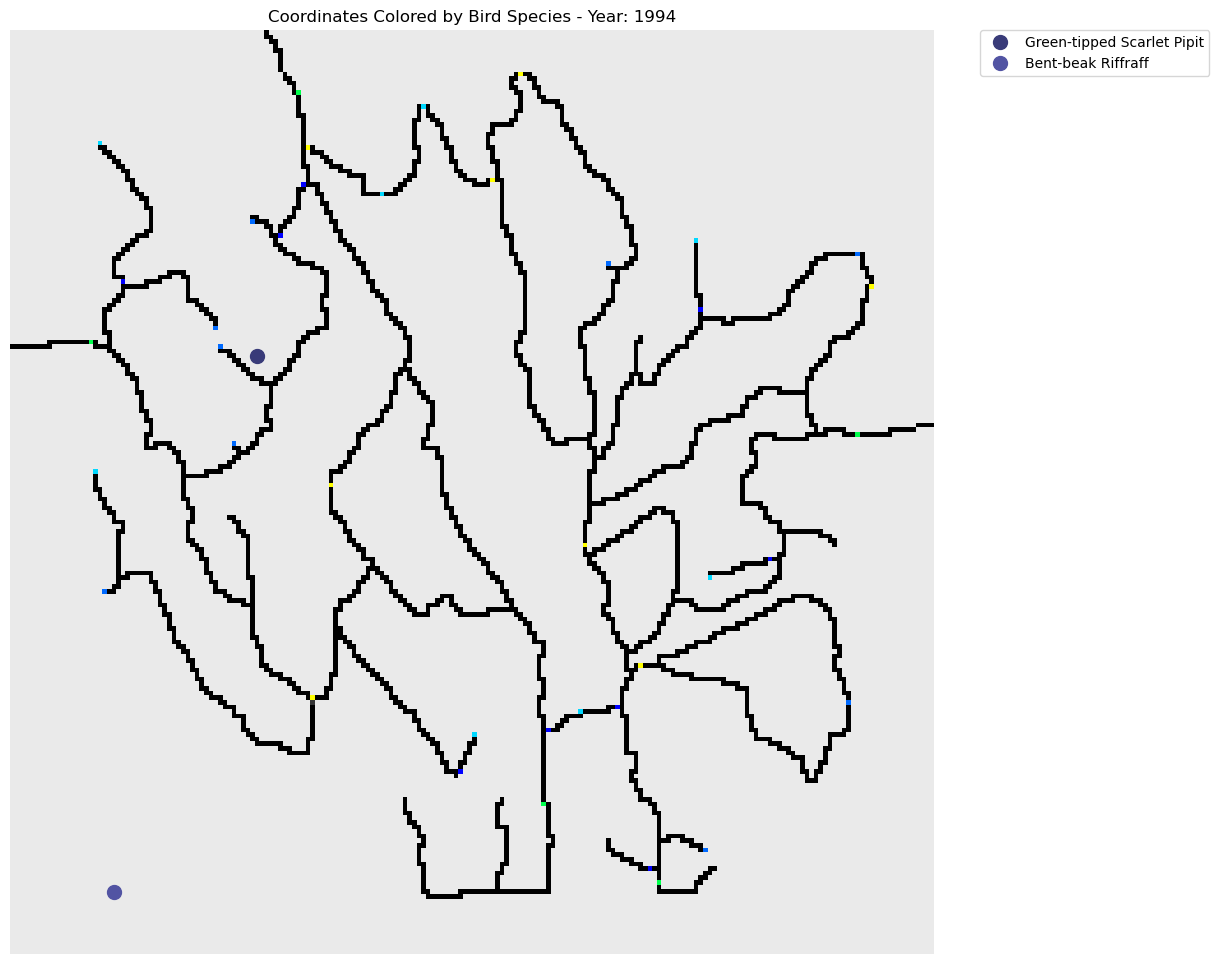

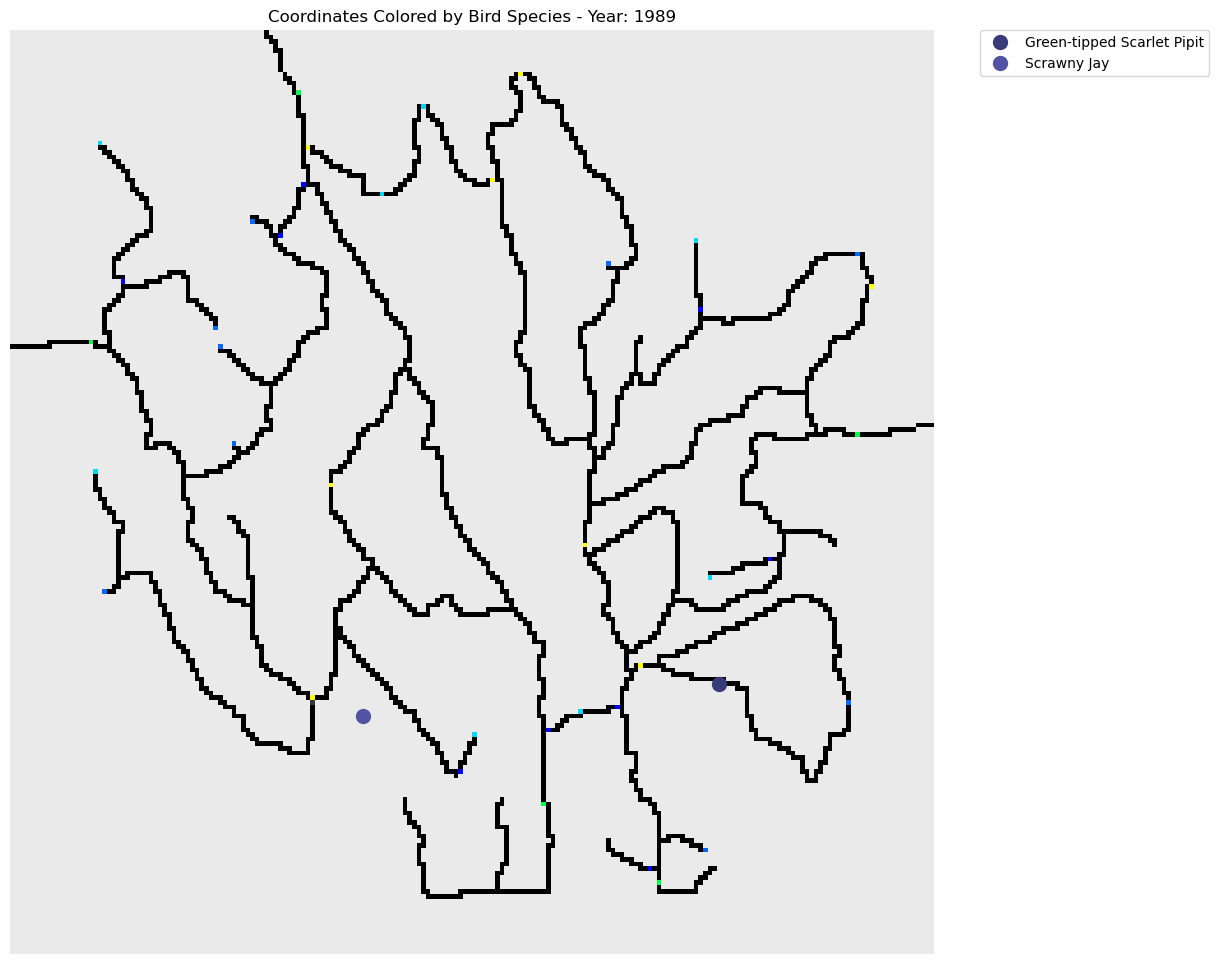

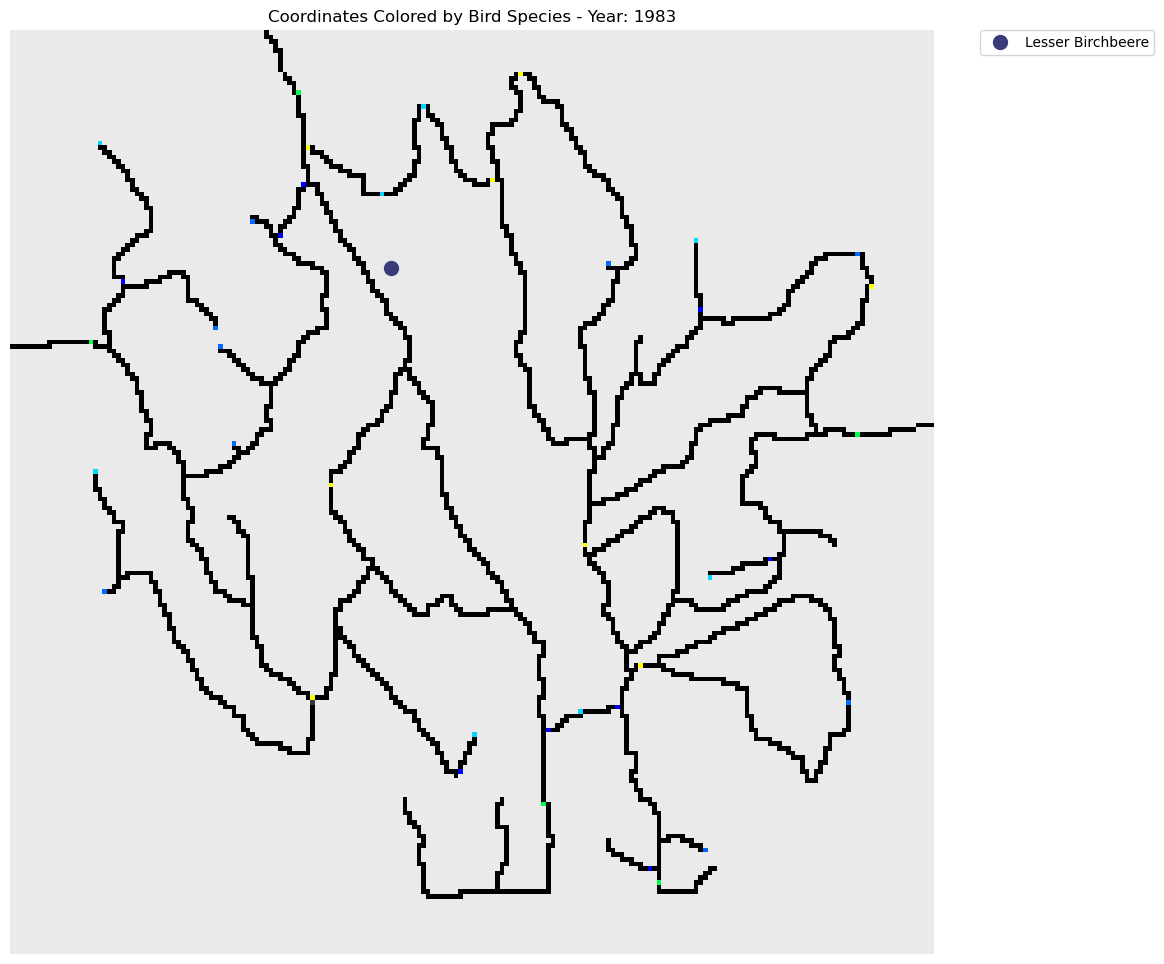

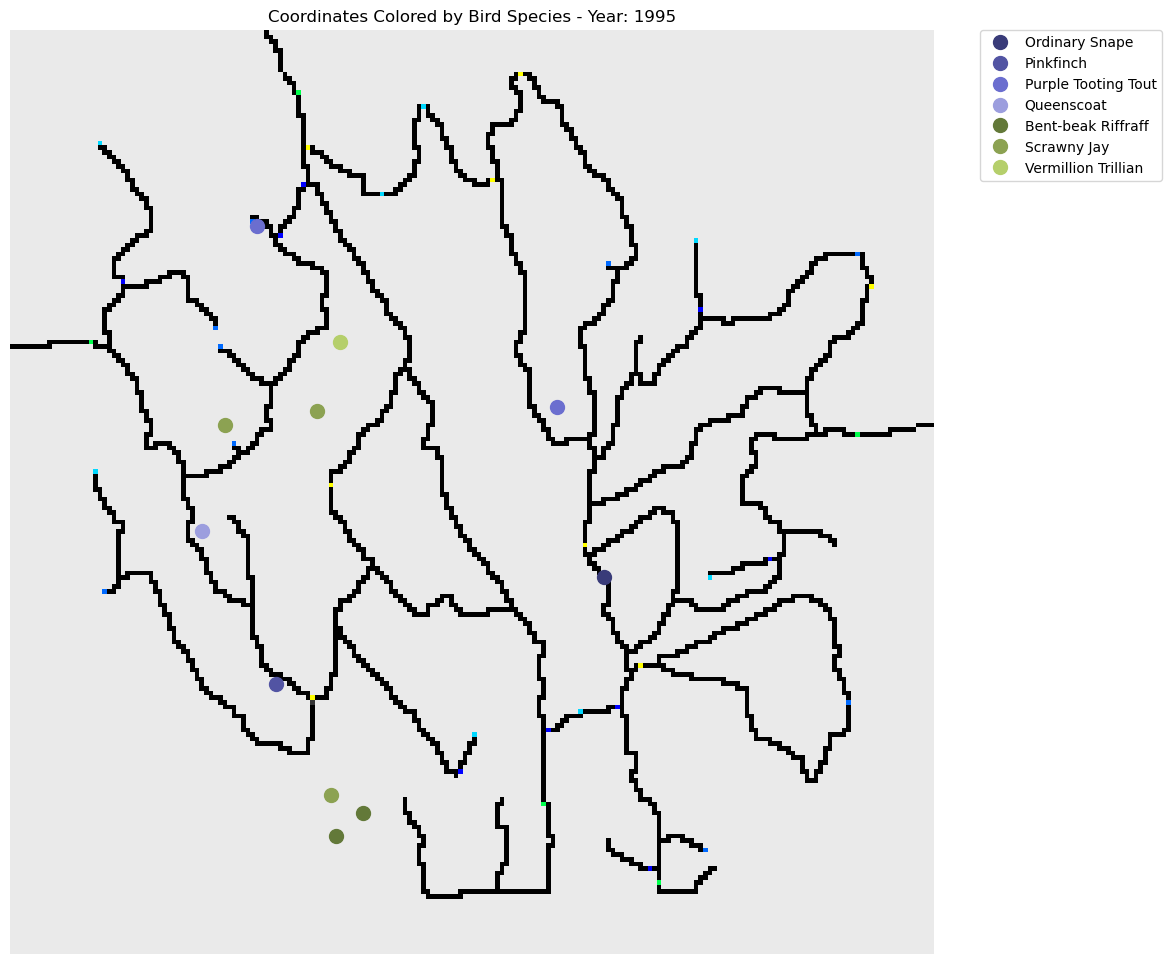

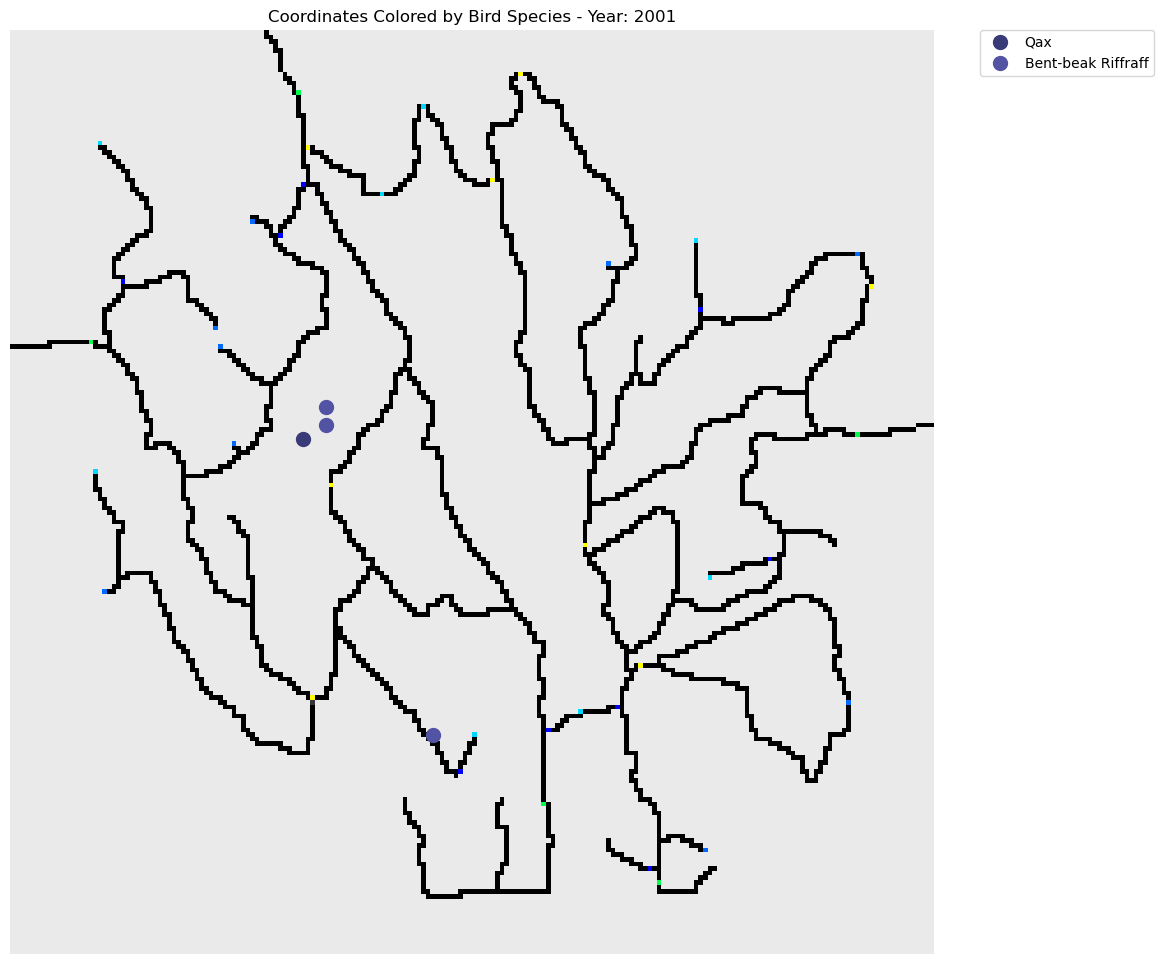

In [96]:
for year in bird_data_filtered['Year'].unique():
    bird_data_by_year = bird_data_filtered.loc[bird_data_filtered['Year'] == year]
    plot_coordinates_by_species(map_image, bird_data_by_year, year, species_col='English_name')

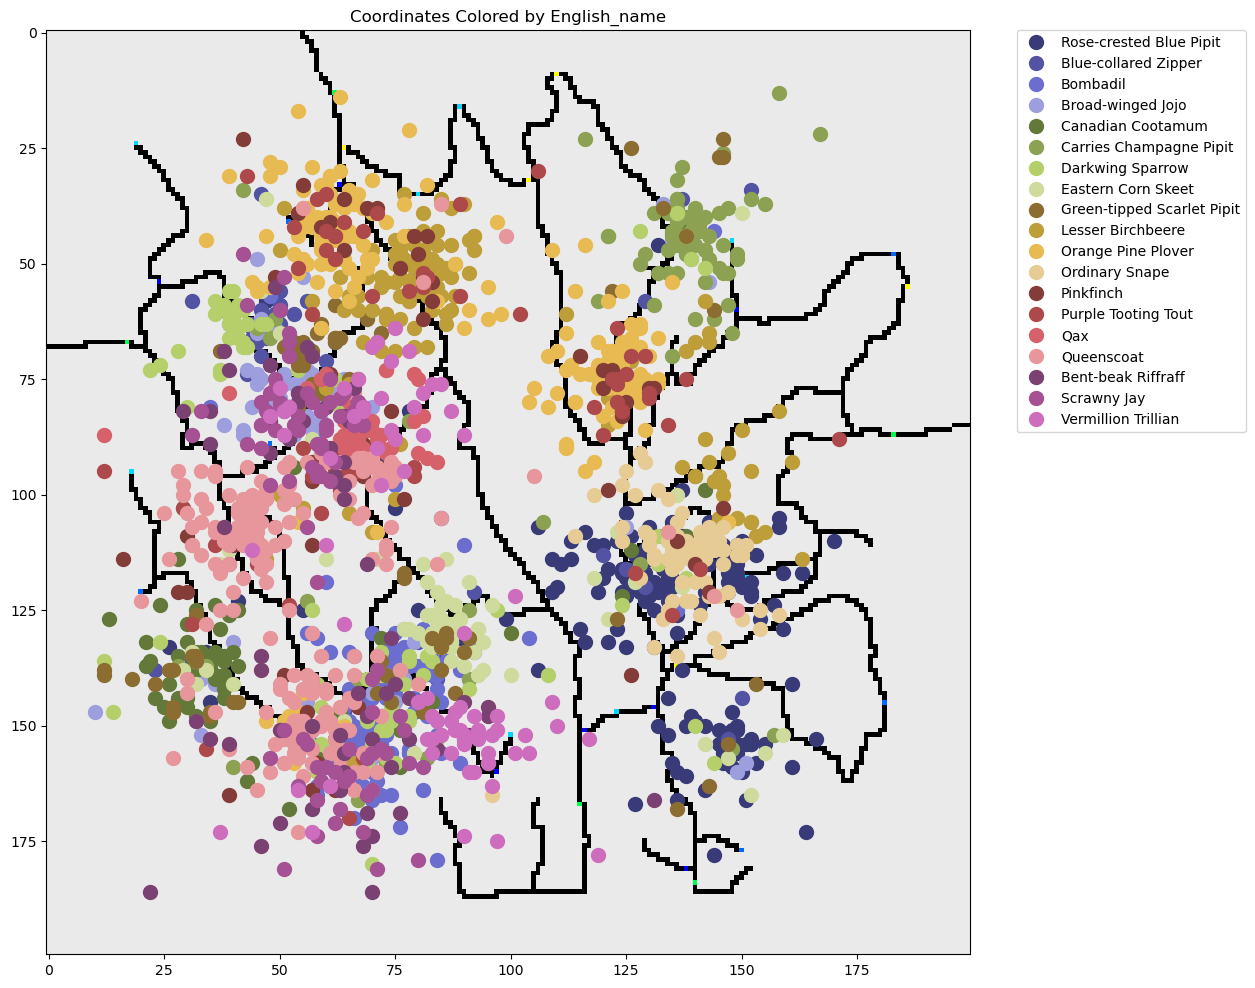

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [97]:
plot_coordinates_by_feature(map_image, bird_data_filtered, 'English_name')

In [110]:
def load_audio(folder, ids):
    sr = 24000  # audio sampling rate; 24kHz sampling rate is good for birdsong
    mp3s = [fileName for fileName in os.listdir(folder) if '.mp3' in fileName]  # list of .mp3 files in the folder

    data = {
        'File ID': [],
        'time_series': [],
        'file_name': []
    }

    i = 0
    for mp3 in mp3s:
        name = mp3.split('.')[0]  # name of mp3 file
        current_id = name.split('-')[-1]

        if int(current_id) in ids:
            data['File ID'].append(current_id)  # use current_id as the File ID
            path = os.path.join(folder, mp3)
            y, _ = librosa.load(path, sr=sr)  # retrieves a numpy array of an audio time series
            data['time_series'].append(y)
            data['file_name'].append(mp3)
        i += 1

    audio_df = pd.DataFrame(data)
    return audio_df

In [111]:
audio_file_path = "/mnt/c/Users/Owner/Desktop/COMP 4449 Capstone/comp-4449-final-cheepshots/ALL BIRDS"
audio_df = load_audio(audio_file_path, bird_data_filtered['File ID'])

/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/sfirestone/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/li

In [109]:
audio_df.head()

File ID                                        time_series  \
0     539  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     751  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      86  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    1366  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4    1202  [0.014659212, -0.004361015, -0.009151704, 0.01...   

                    file_name  
0  Bent-Beak-Riffraff-539.mp3  
1  Bent-Beak-Riffraff-751.mp3  
2   Bent-Beak-Riffraff-86.mp3  
3           Bombadil-1366.mp3  
4  Broad-winged-Jojo-1202.mp3

In [114]:
bird_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1924 entries, 1 to 2074
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   File ID            1924 non-null   int64 
 1   English_name       1924 non-null   object
 2   Vocalization_type  1924 non-null   object
 3   Quality            1924 non-null   object
 4   Time               1924 non-null   object
 5   Date               1889 non-null   object
 6   X                  1924 non-null   int64 
 7   Y                  1924 non-null   int64 
 8   time_of_day        1924 non-null   object
 9   Month              1924 non-null   int64 
 10  Day                1924 non-null   int64 
 11  Year               1924 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 259.9+ KB


In [118]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   File ID      12 non-null     object
 1   time_series  12 non-null     object
 2   file_name    12 non-null     object
dtypes: object(3)
memory usage: 416.0+ bytes


In [119]:
# convert File ID to int
audio_df['File ID'] = audio_df['File ID'].astype(int)

In [115]:
# convert English_name to string
bird_data_filtered['English_name'] = bird_data_filtered['English_name'].astype(str)

/tmp/ipykernel_387/1910691485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_data_filtered['English_name'] = bird_data_filtered['English_name'].astype(str)


In [120]:
merged_audio_df = pd.merge(audio_df, bird_data_filtered[['English_name']], on='File ID', how='left')
merged_audio_df.head()

KeyError: 'File ID'